# Ma 412 - Mathematical Foundations for Statistical Learning
## Multi-Label Classification of Scientific Literature Using the NASA SciX Corpus

#### Import requiered for the project

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

#### Download dataset

In [ ]:
splits = {'train': 'data/train-00000-of-00001-b21313e511aa601a.parquet', 'val': 'data/val-00000-of-00001-66ce8665444026dc.parquet'}
df = pd.read_parquet("hf://datasets/adsabs/SciX_UAT_keywords/" + splits["train"]) # load training data
df_1 = pd.read_parquet("hf://datasets/adsabs/SciX_UAT_keywords/" + splits["val"]) # load validation data

df = pd.concat([df, df_1], ignore_index=True) # concatenate train and validation data

## 1. Data Exploration and Preprocessing

First we drop the 'bibcode' and 'verified_uat_ids' columns which are not usefull for the project.
Then we combine the 'title' and 'abstract' into an unique 'text' column

In [ ]:
df.drop(columns=['bibcode', 'verified_uat_ids'], inplace=True) # Remove unnecessary columns
df['text']=df['title']+' '+df['abstract'] # Combine title and abstract into a single text column
df.drop(columns=['title','abstract'], inplace=True) # Drop original title and abstract columns

After that we convert the 'verfied_uat_labels' column into N column of binary unique label (value are 0 the label si not associated with the article and 1 the label is associated with the article) 

In [ ]:
# Extract unique labels from the 'verified_uat_labels' column
unique_labels = set(label for labels in df['verified_uat_labels'] for label in labels)
L = list(unique_labels)

# add binary columns for each label
for label in L:
    df[label] = df['verified_uat_labels'].apply(lambda labels: int(label in labels))

df.drop(columns=['verified_uat_labels'], inplace=True)


#### Analysing the dataset 

This section provides a detailed overview of the dataset and its label distribution, with a focus on identifying and addressing potential issues related to data imbalance.
- Number of occurence for each label
- Number of label assossiate for each article

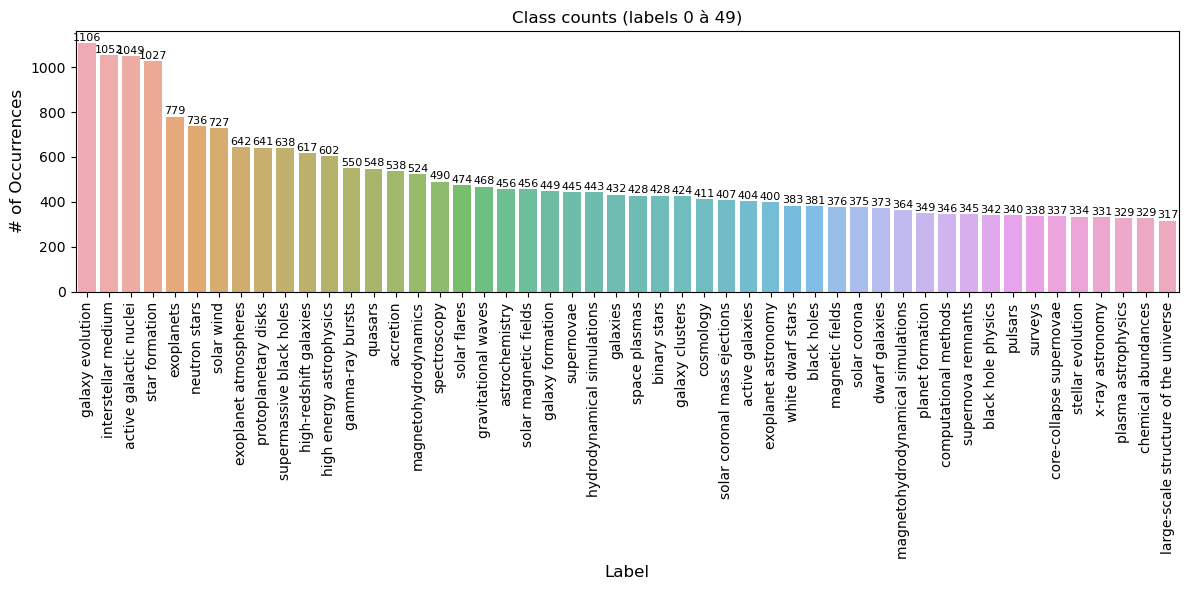

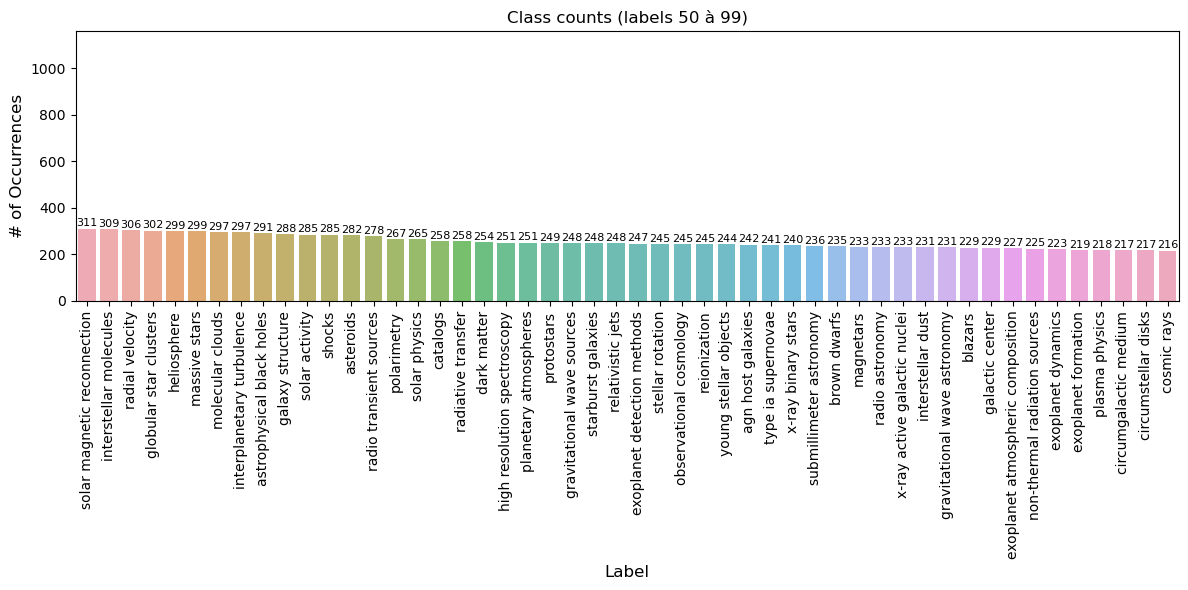

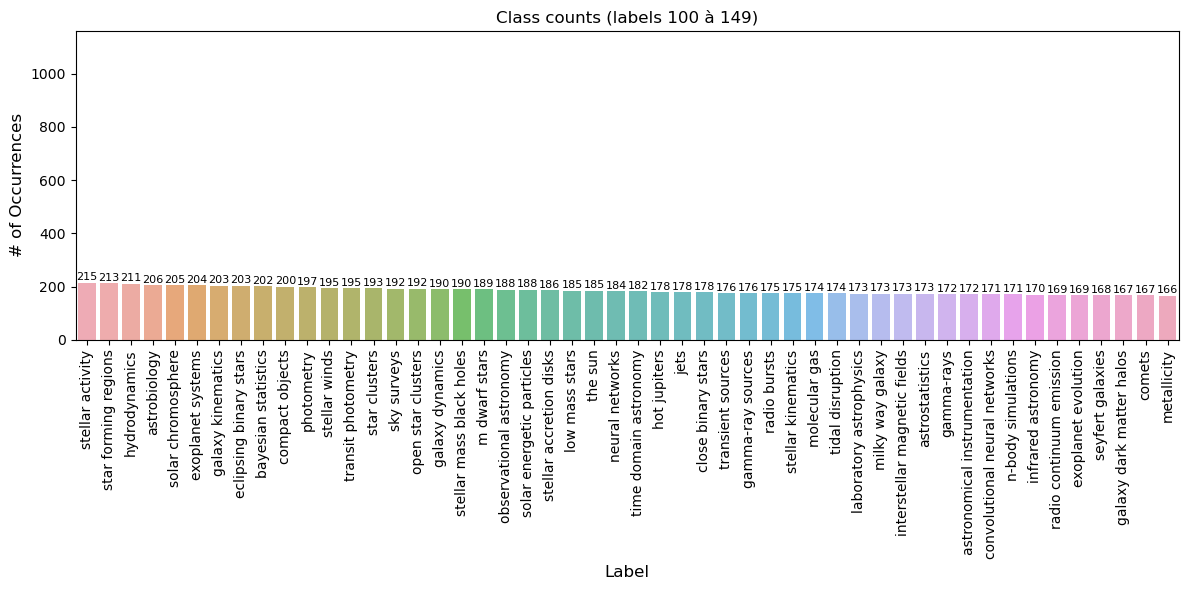

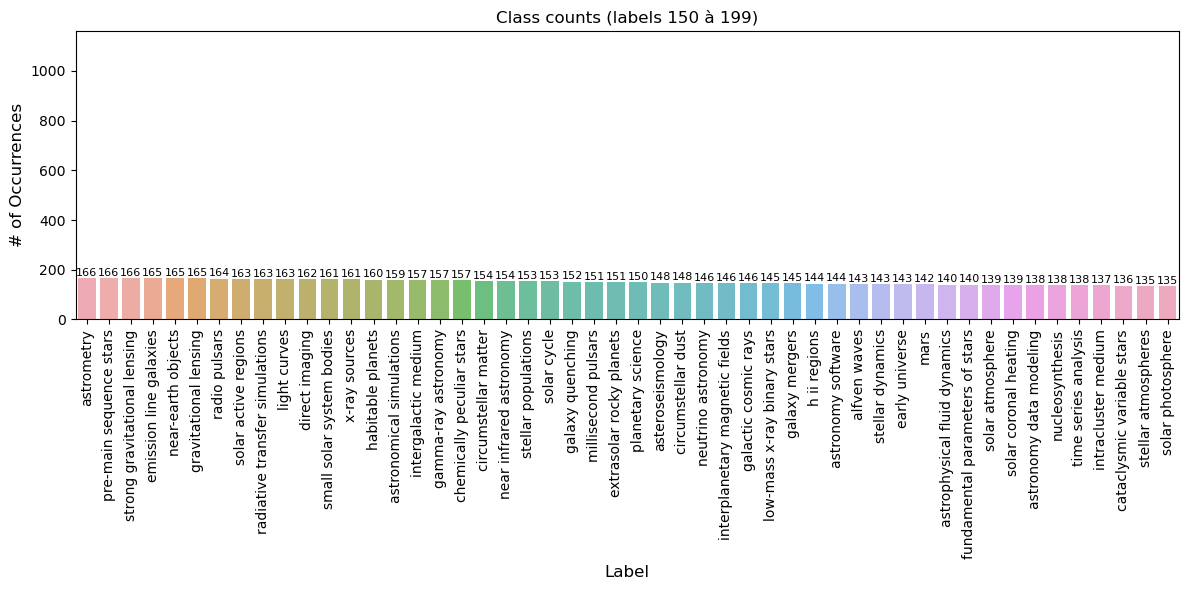

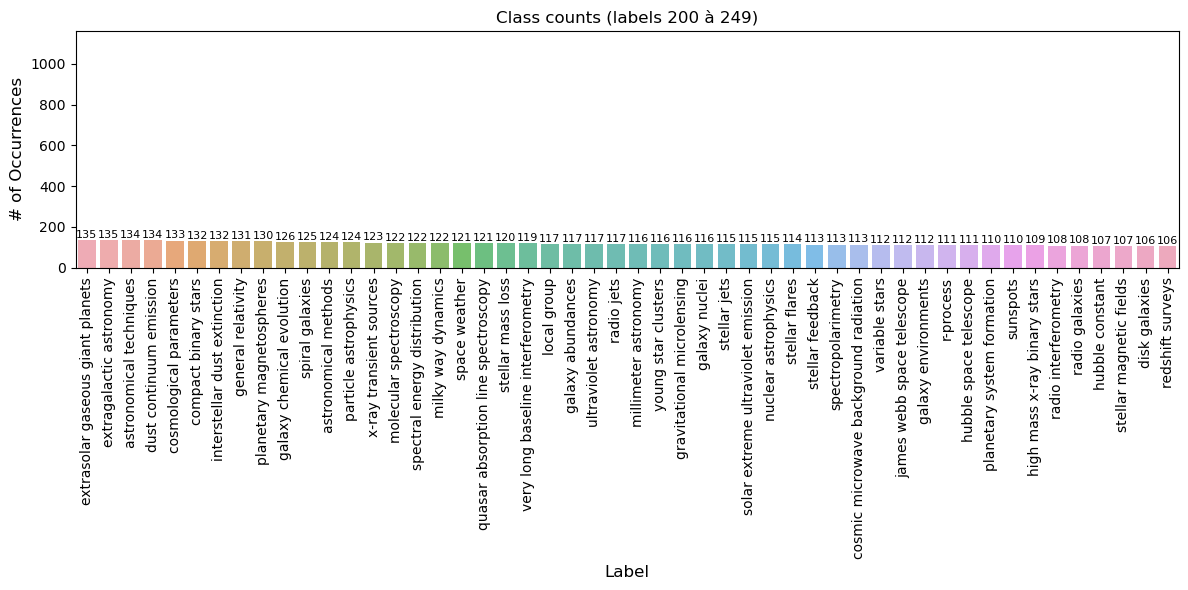

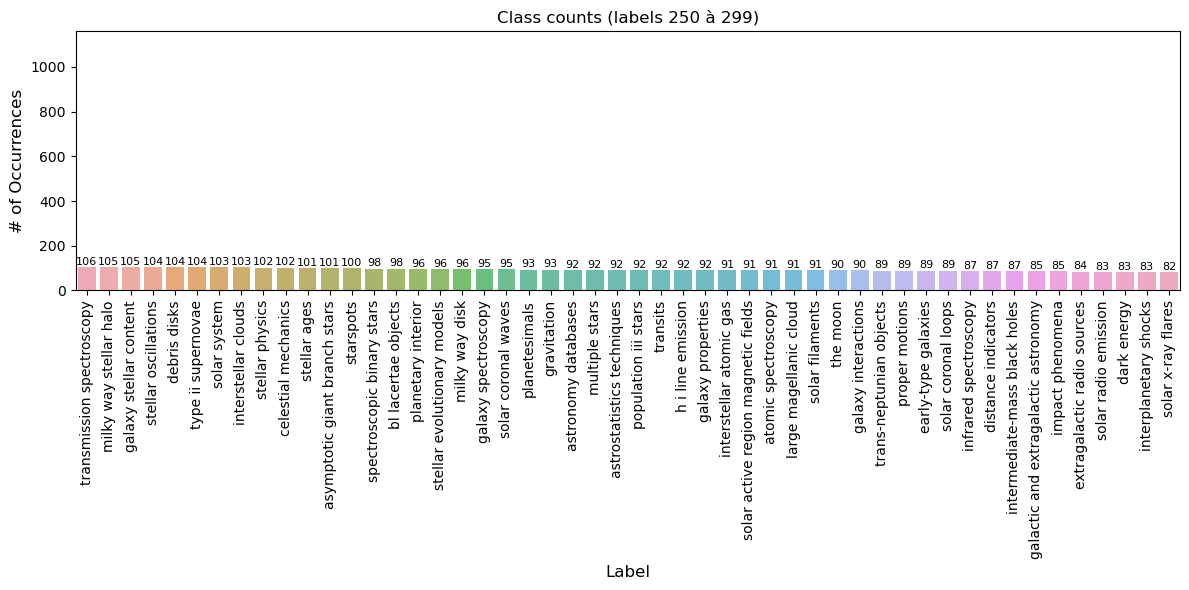

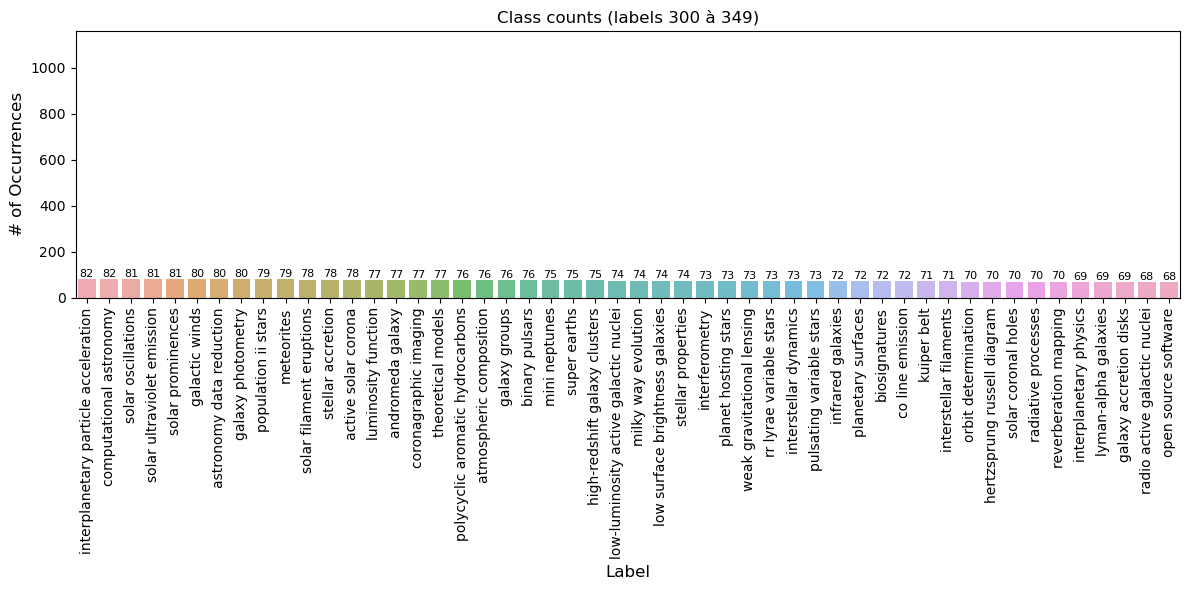

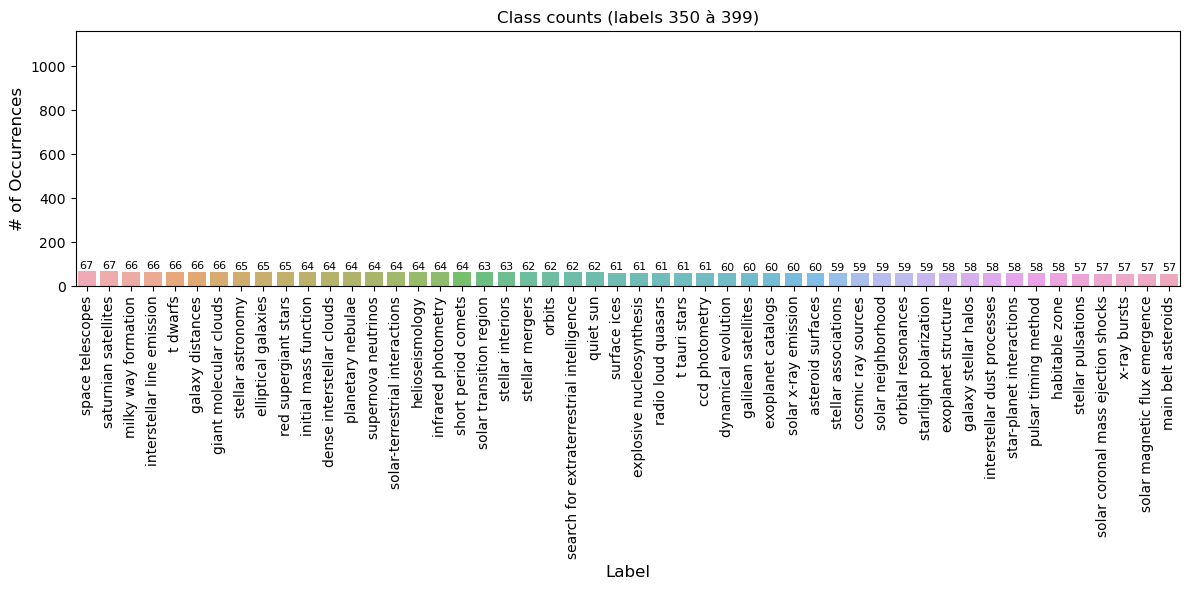

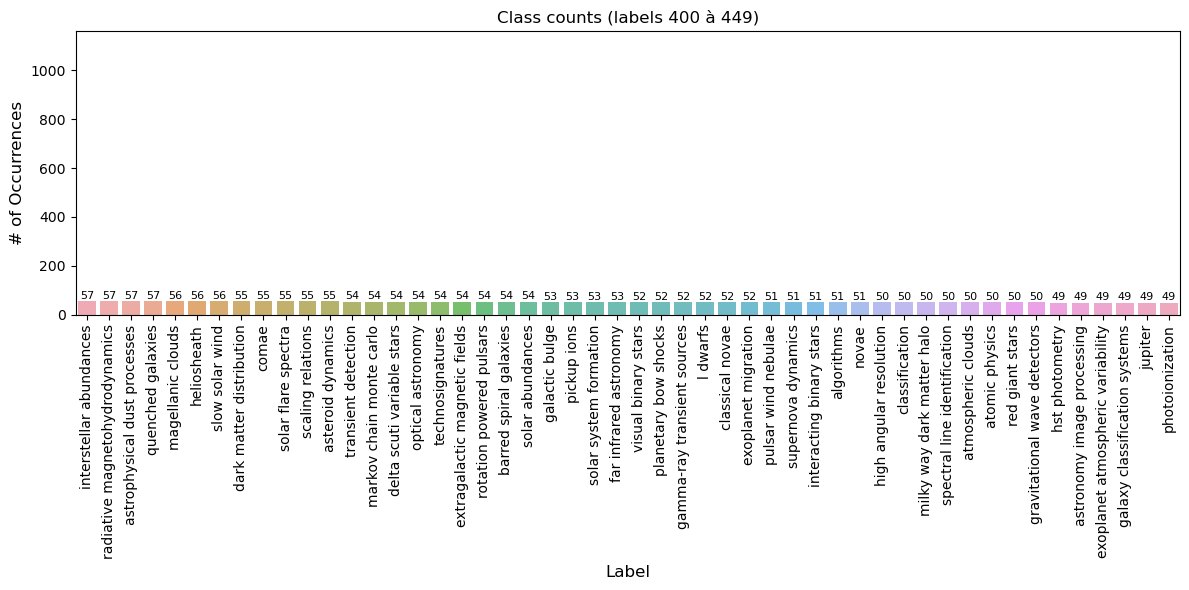

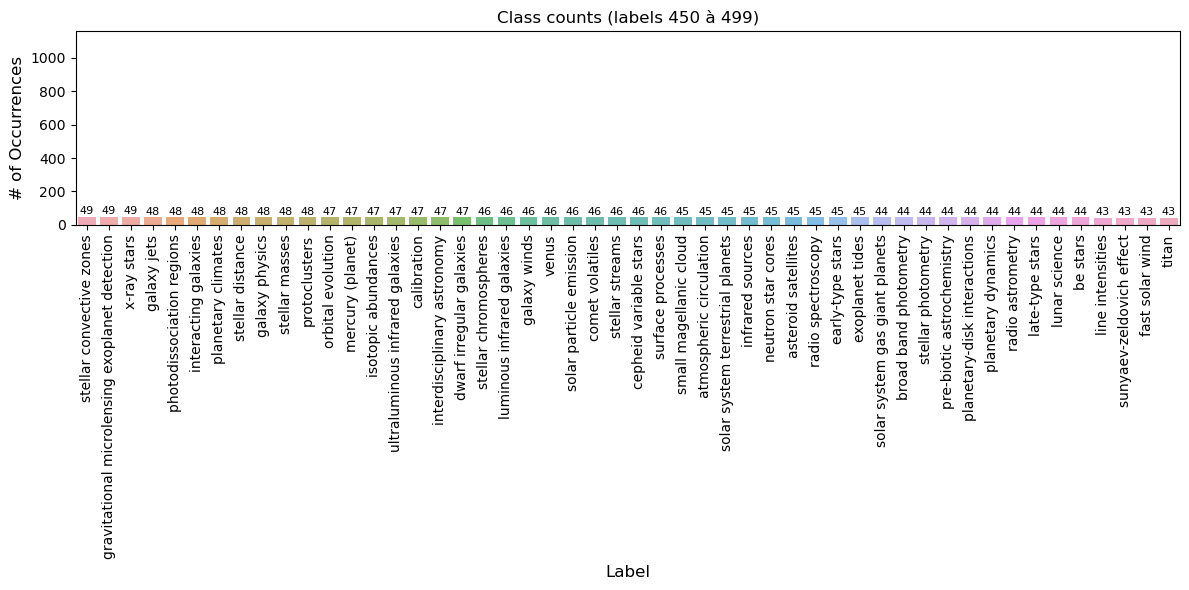

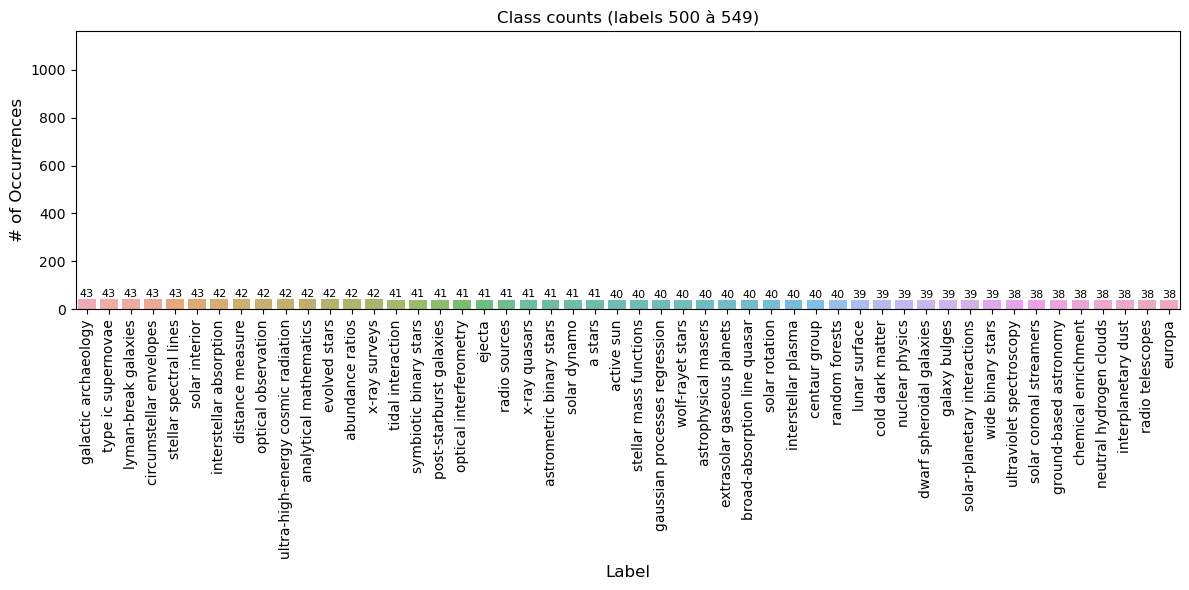

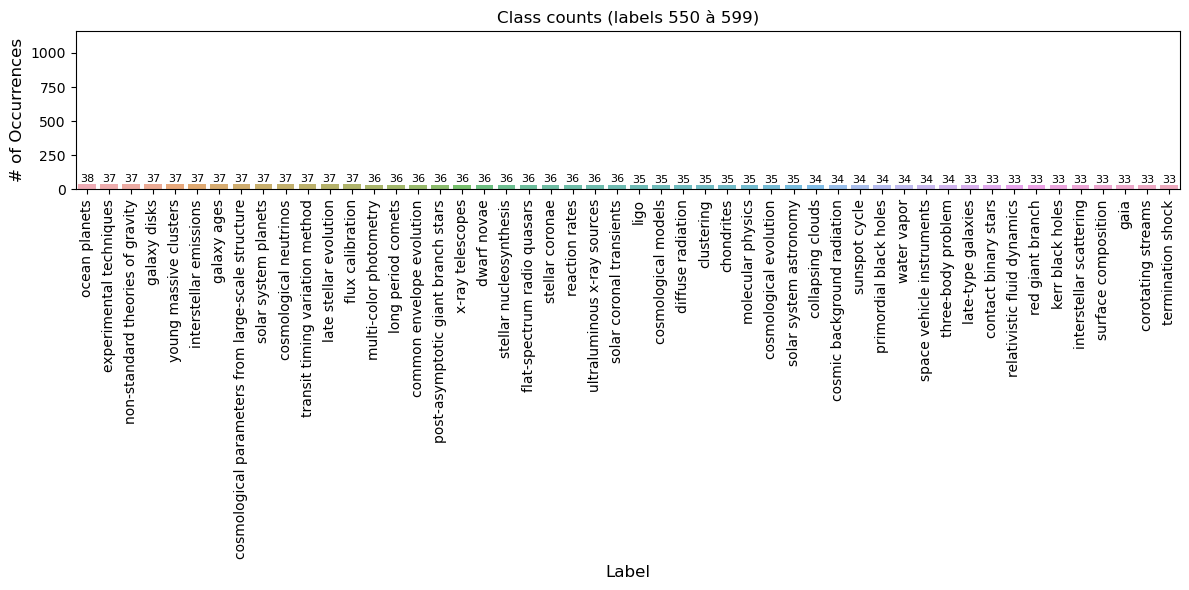

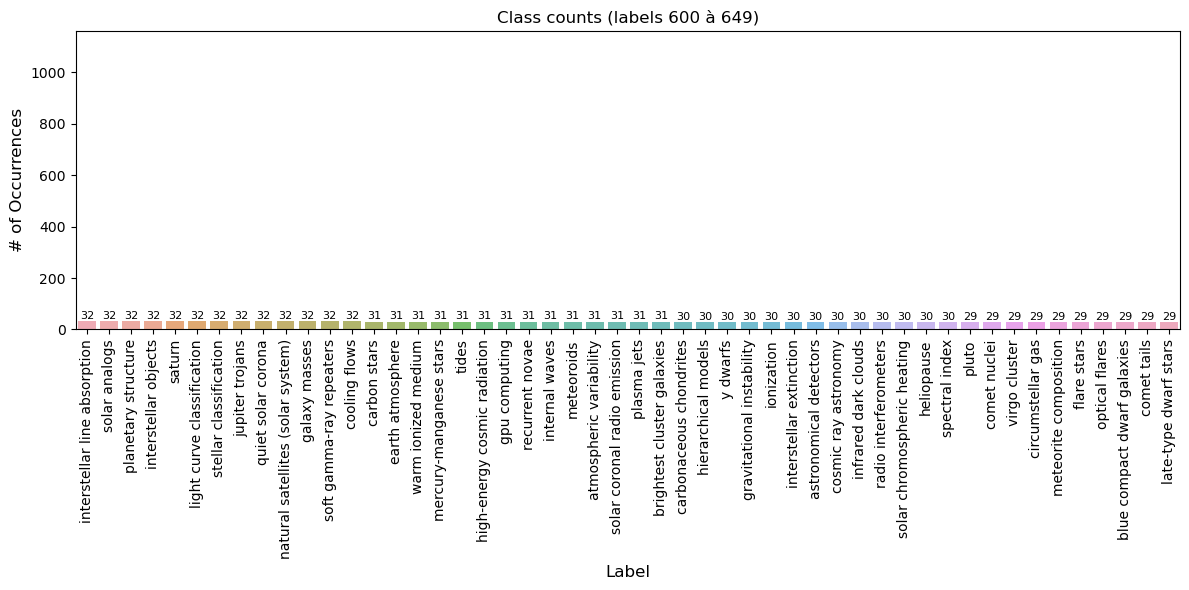

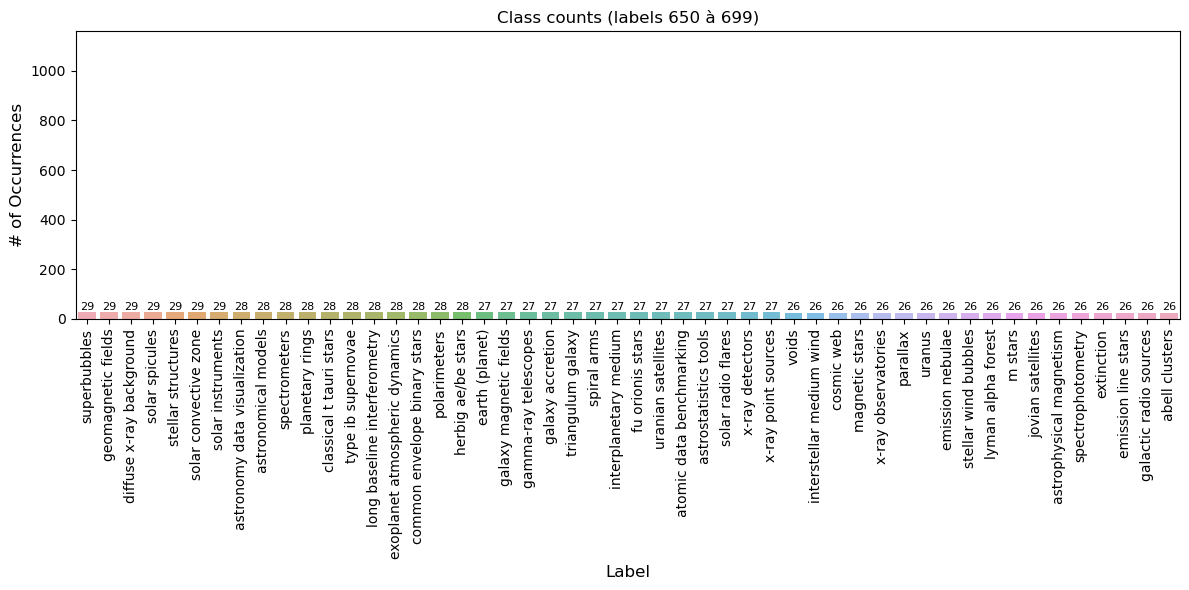

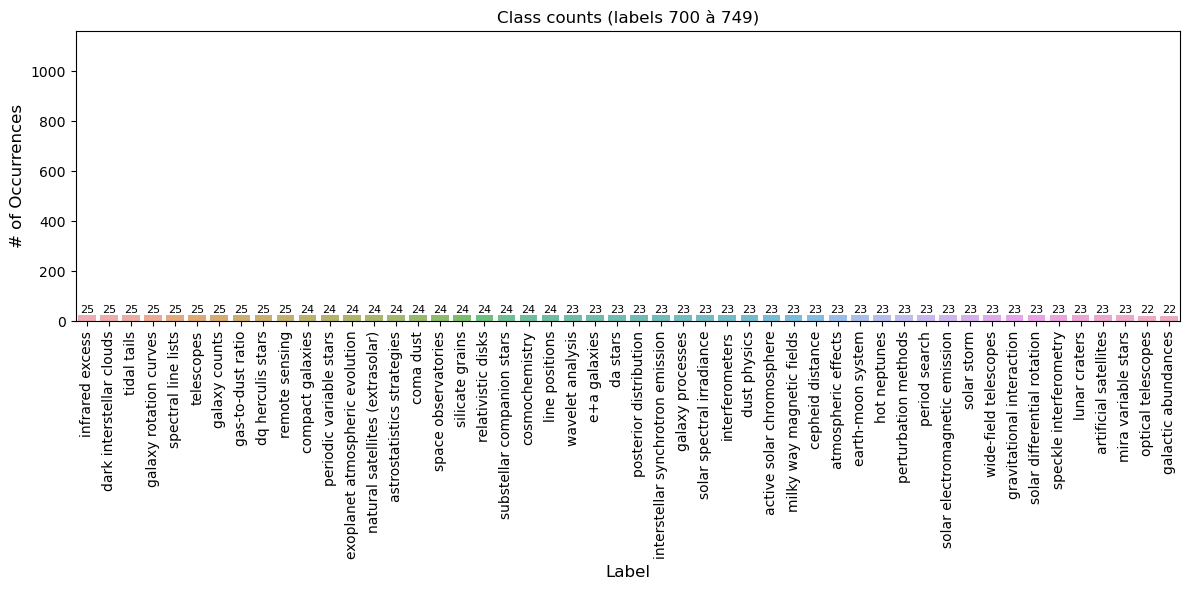

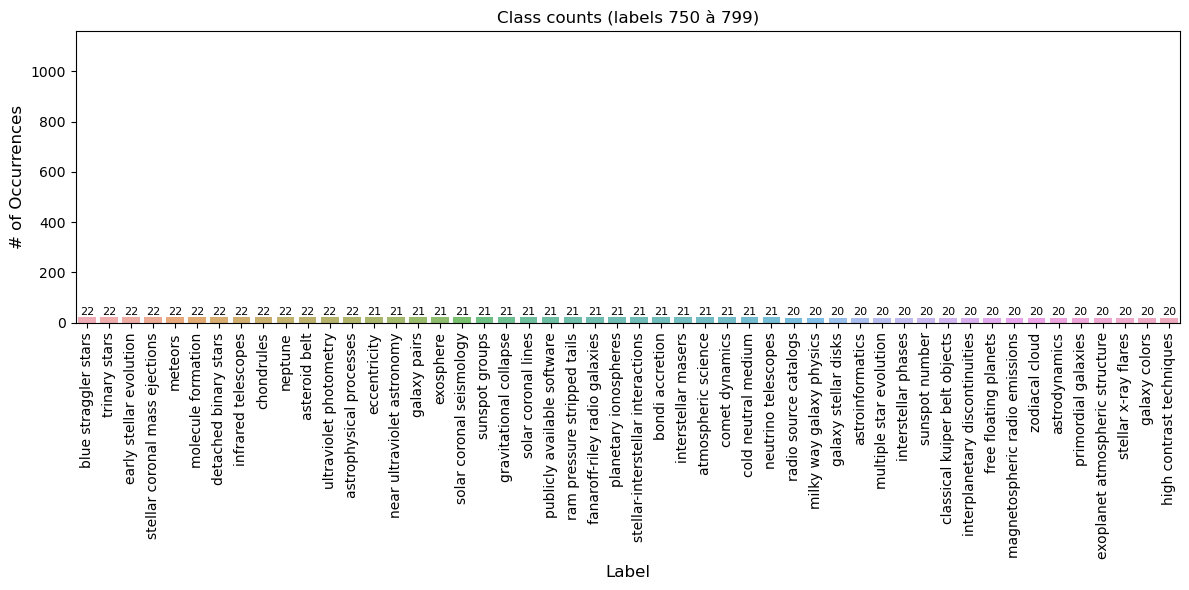

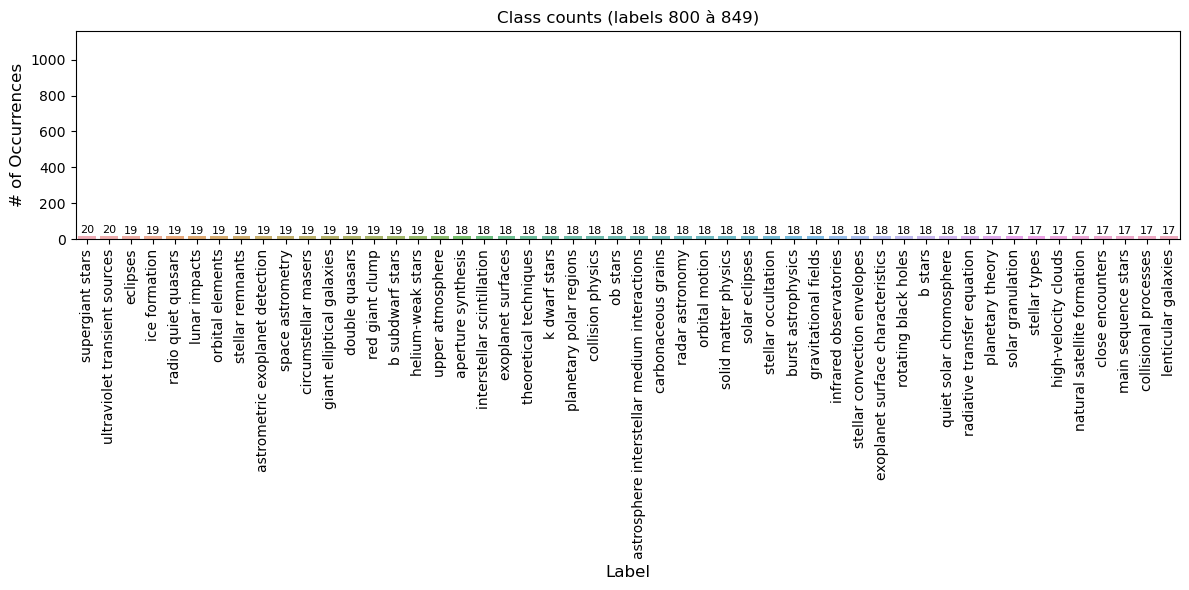

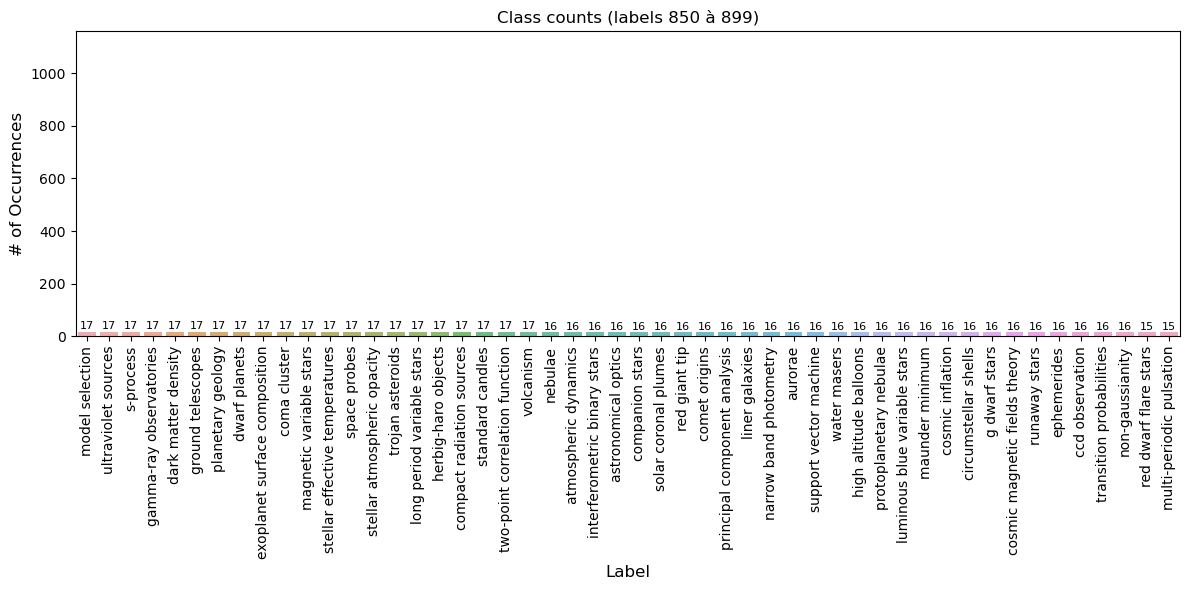

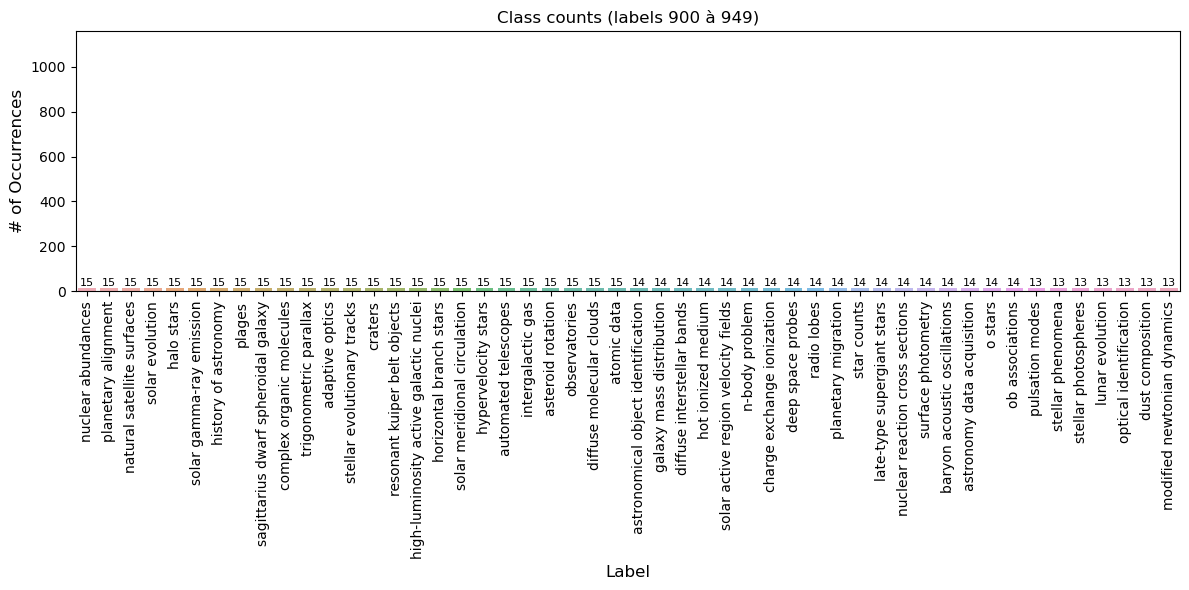

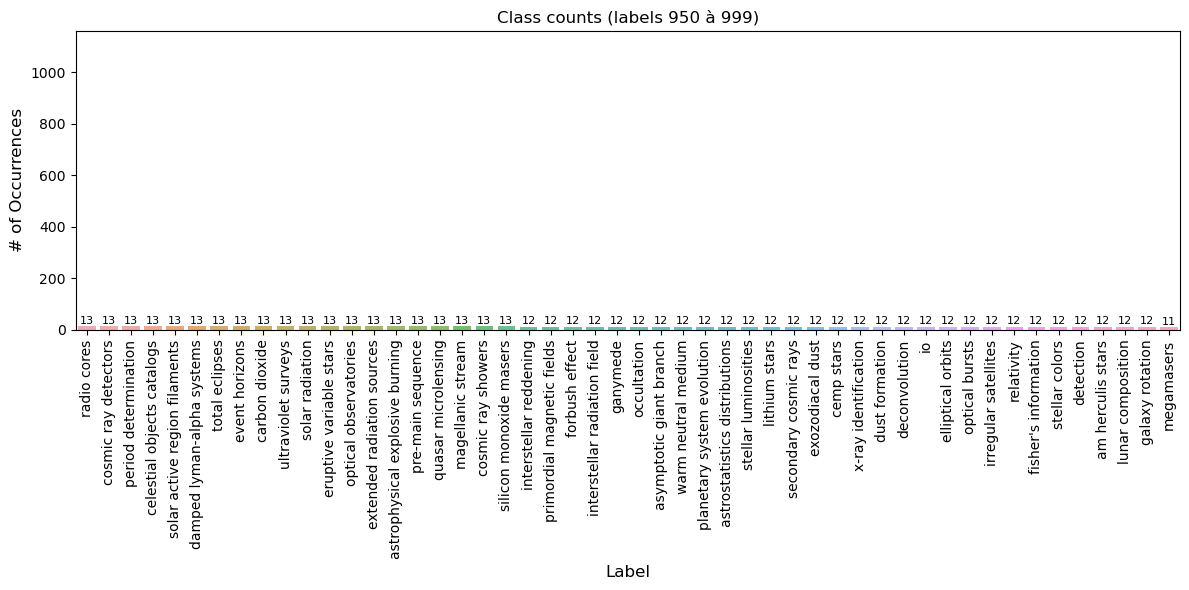

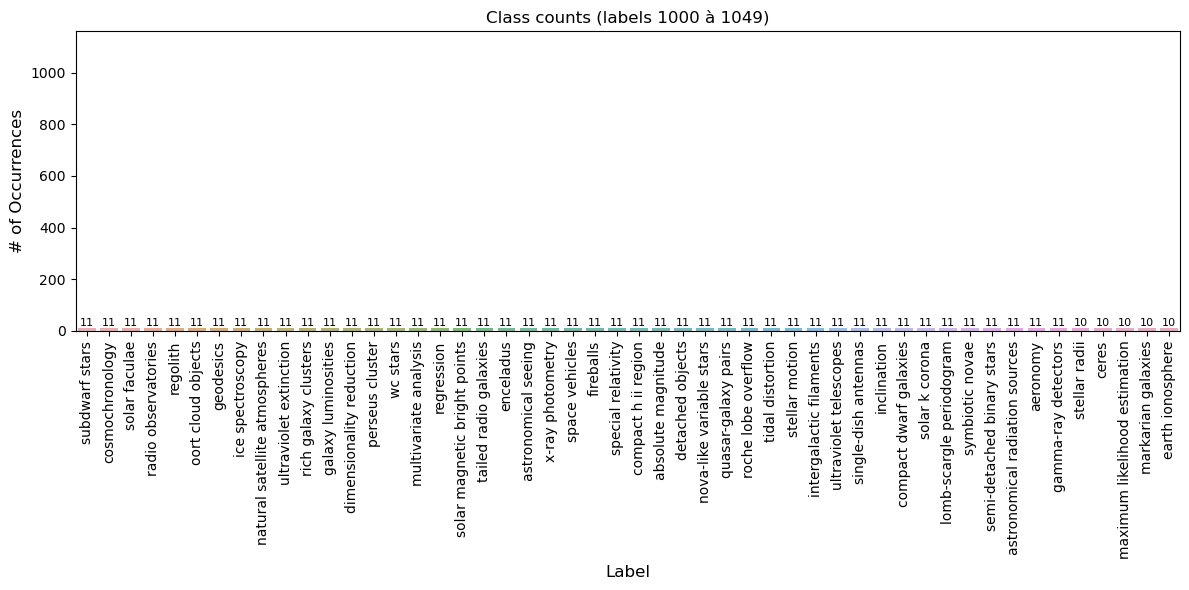

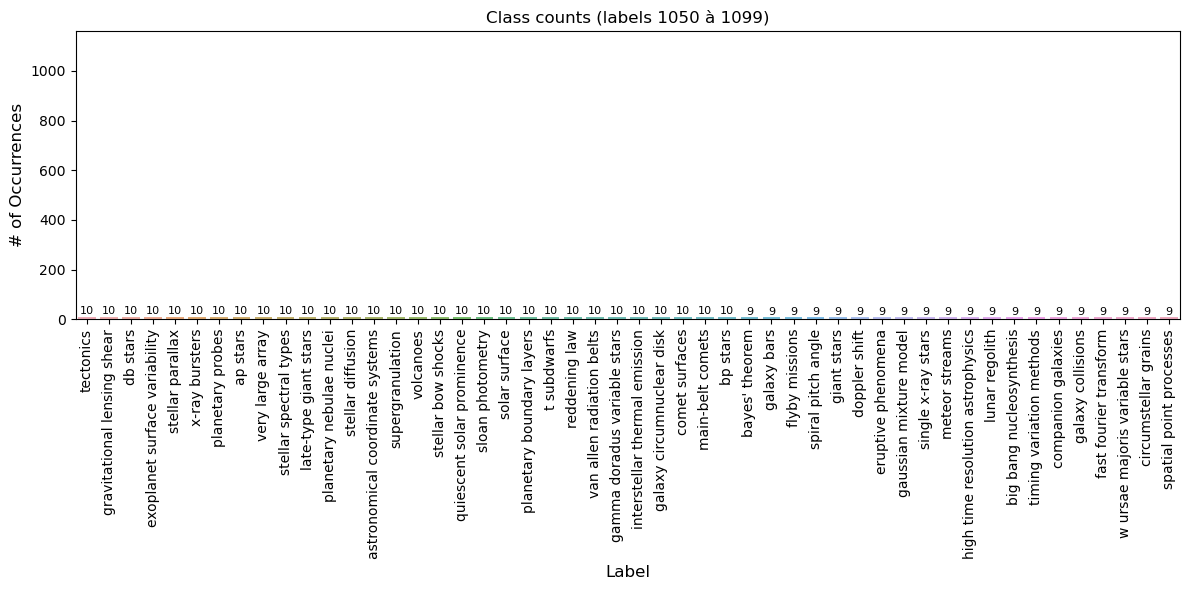

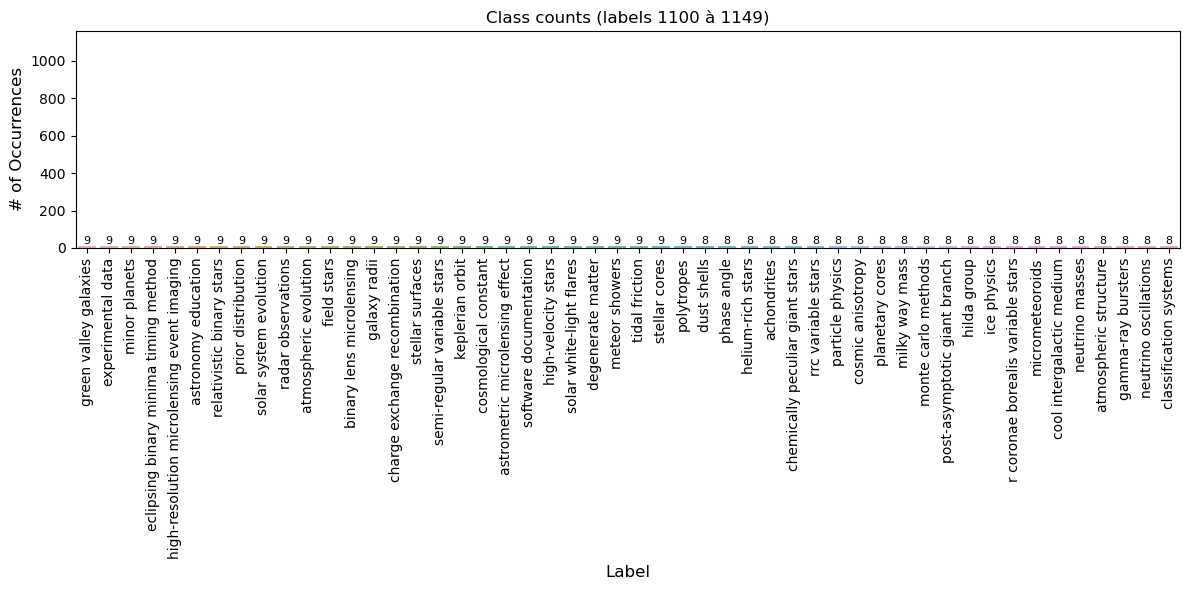

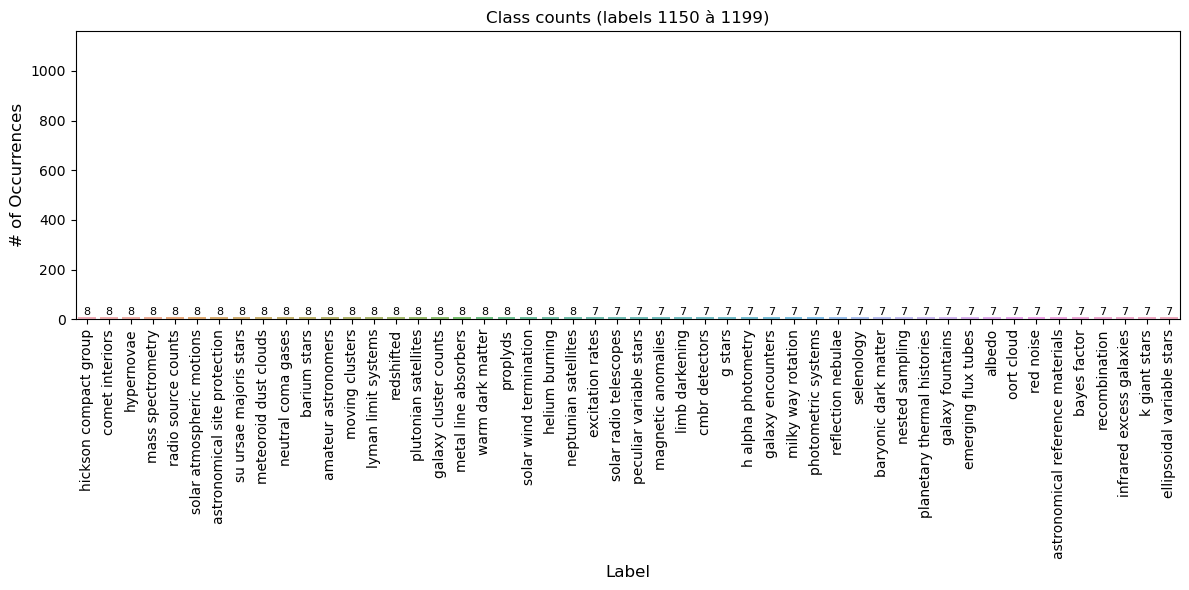

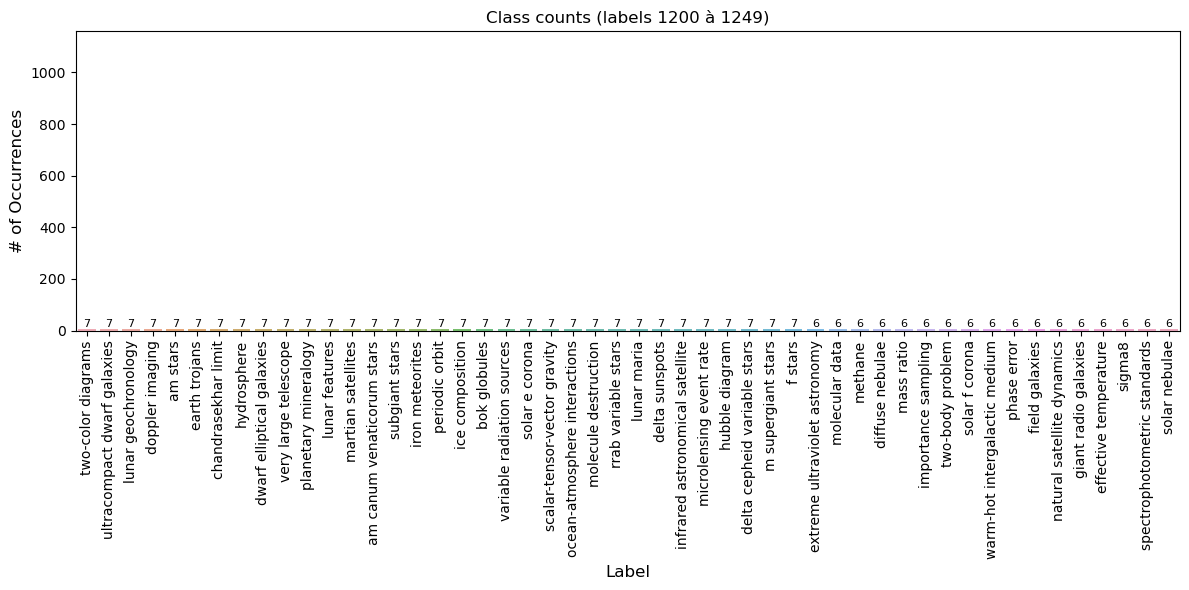

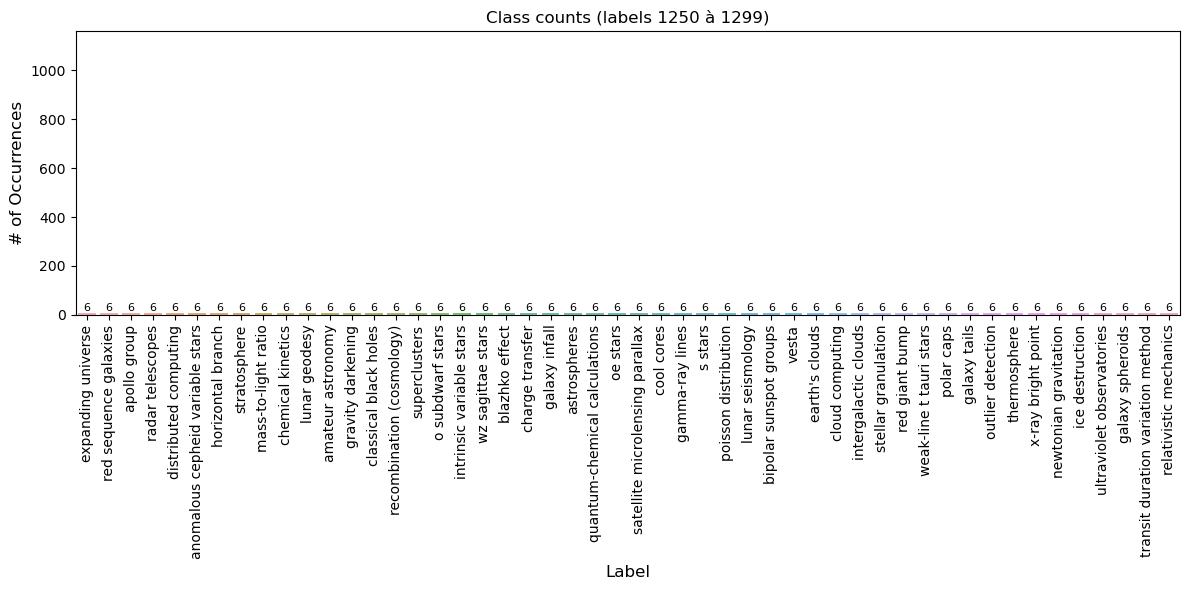

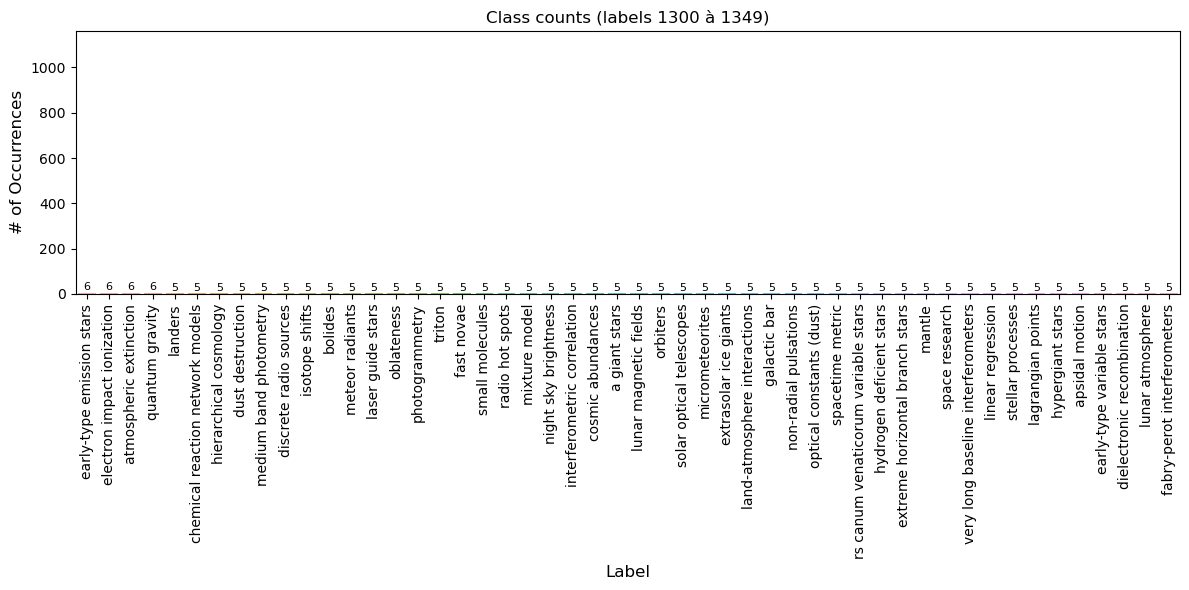

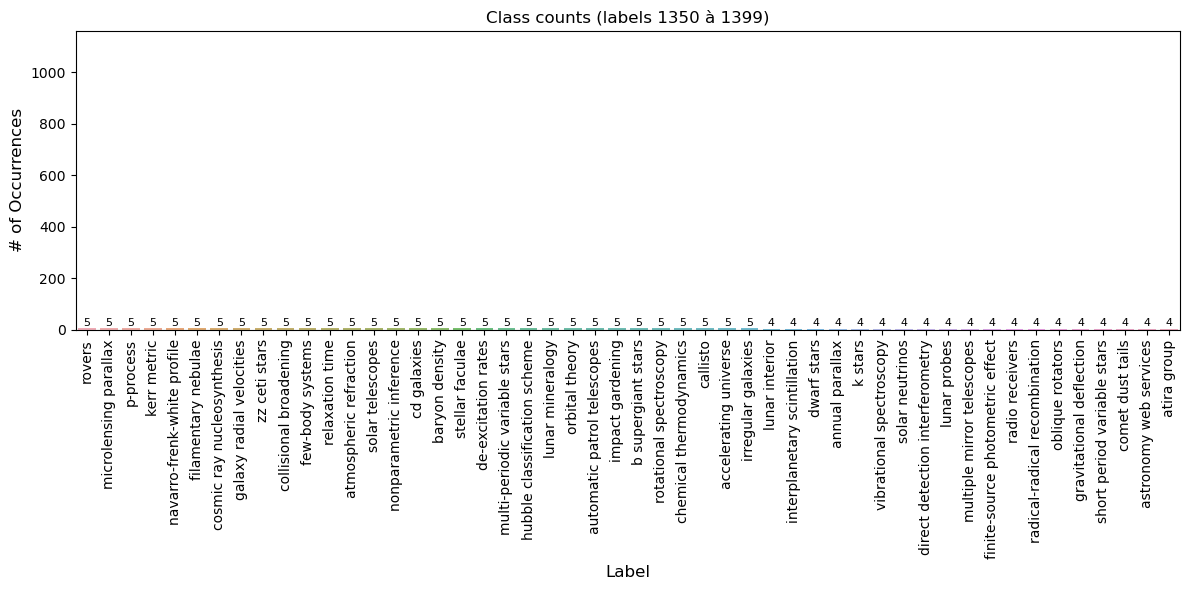

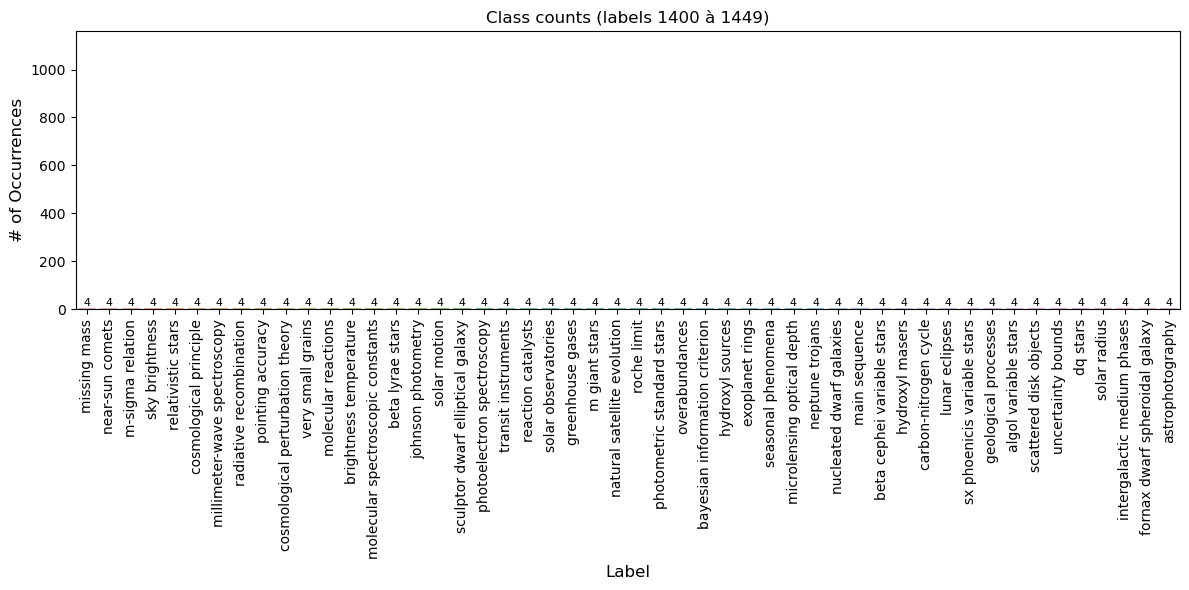

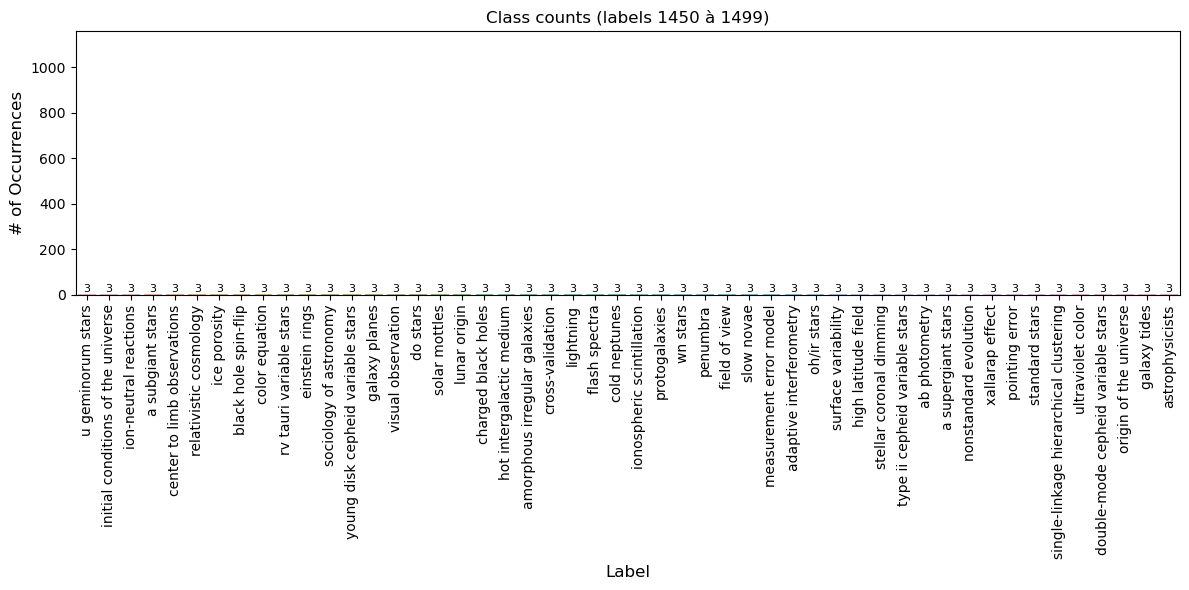

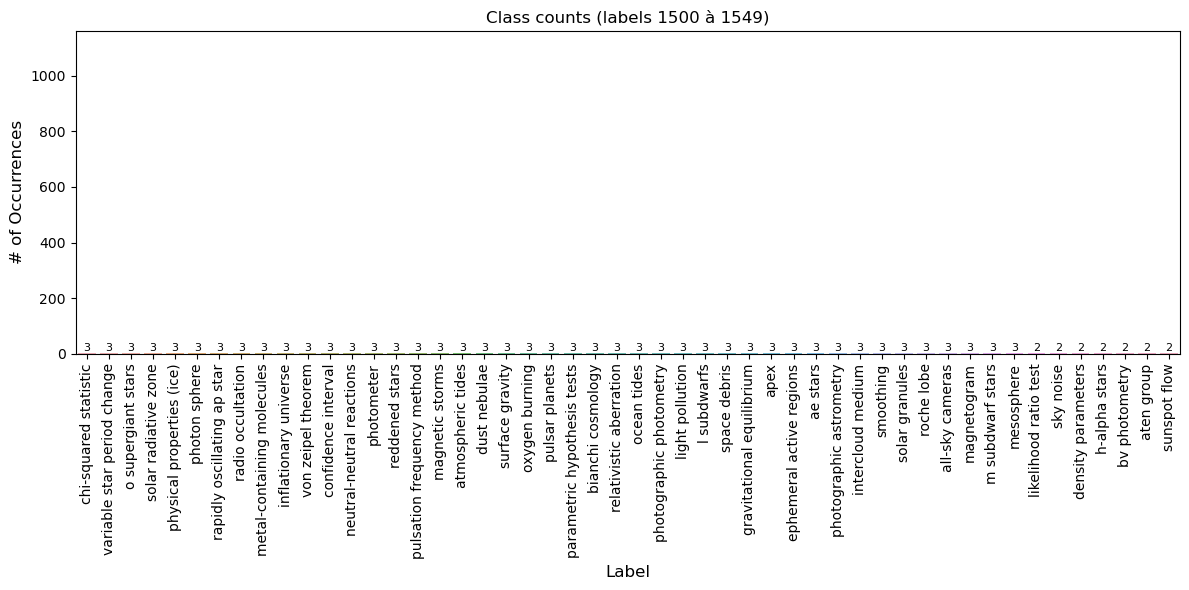

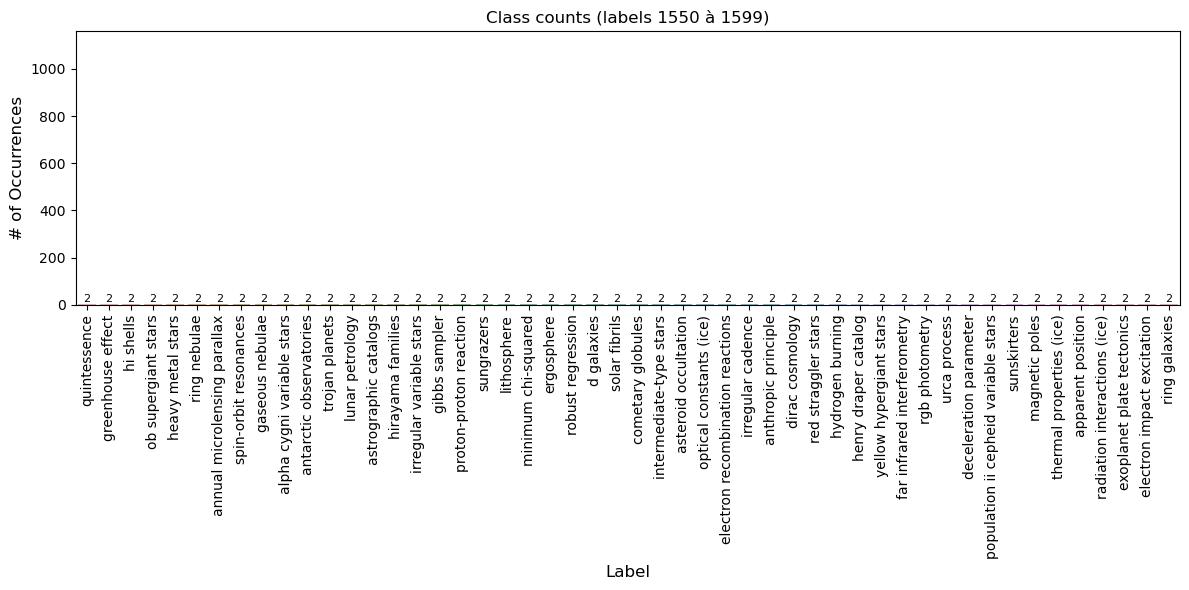

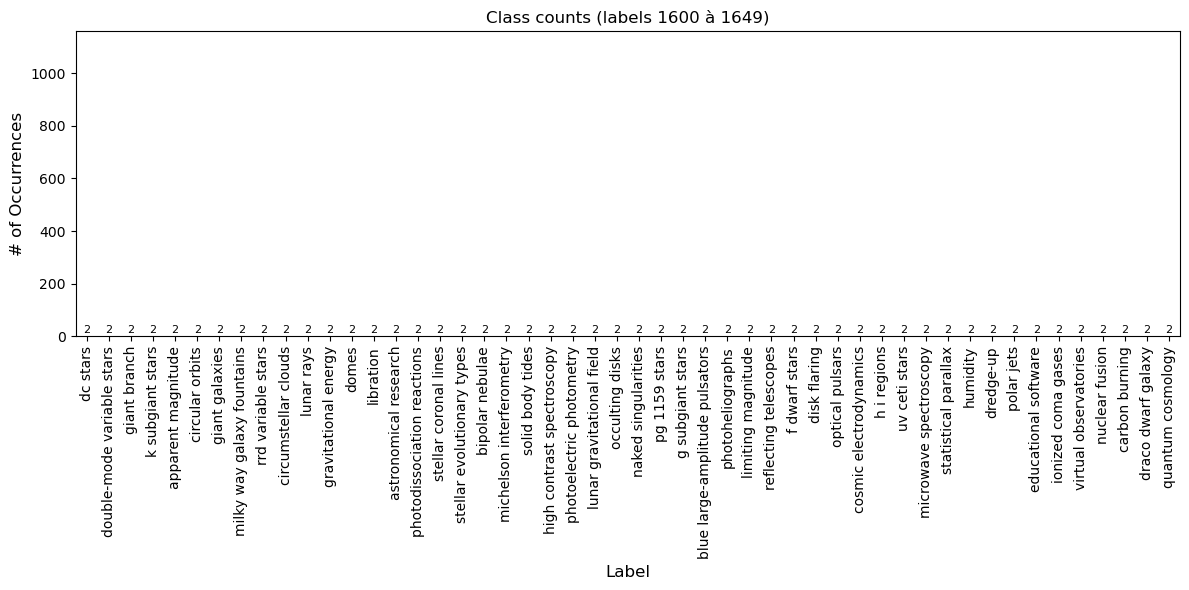

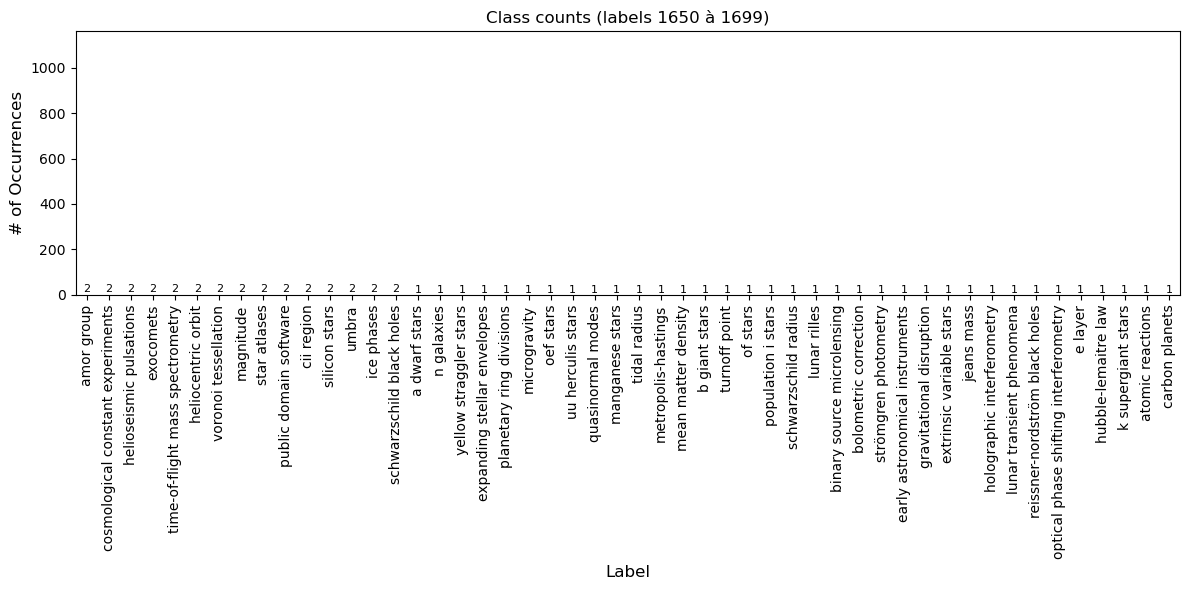

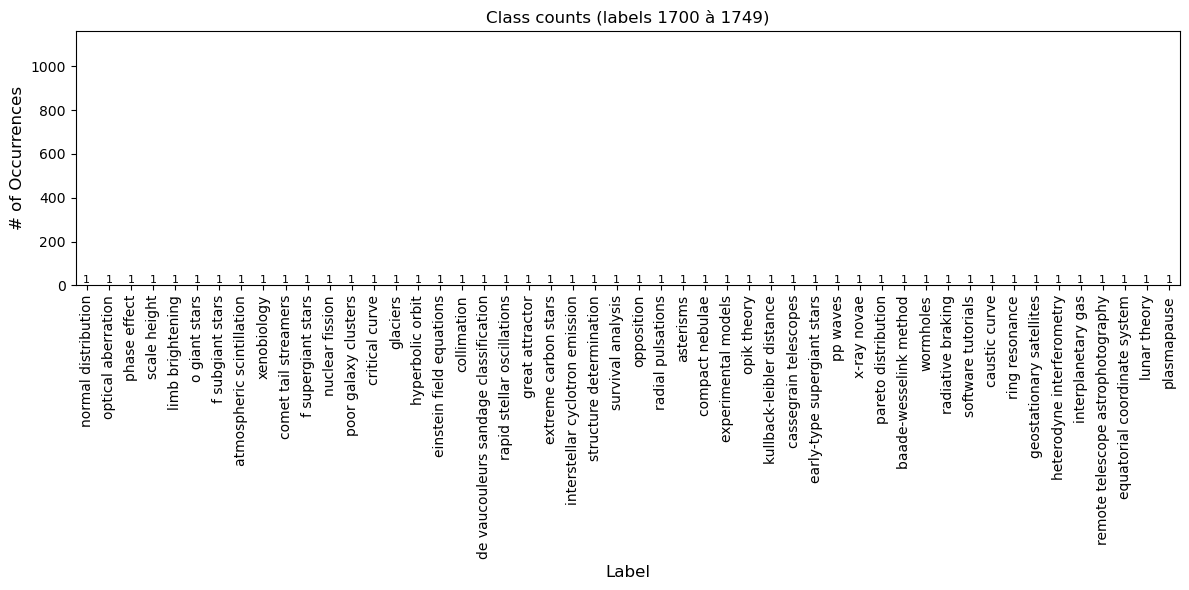

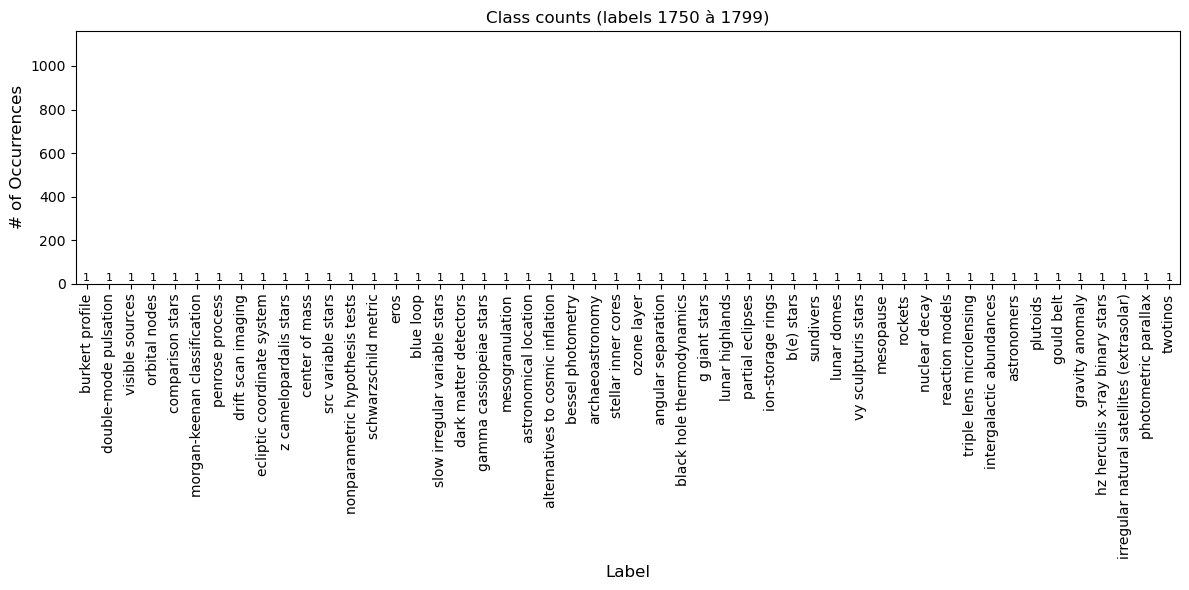

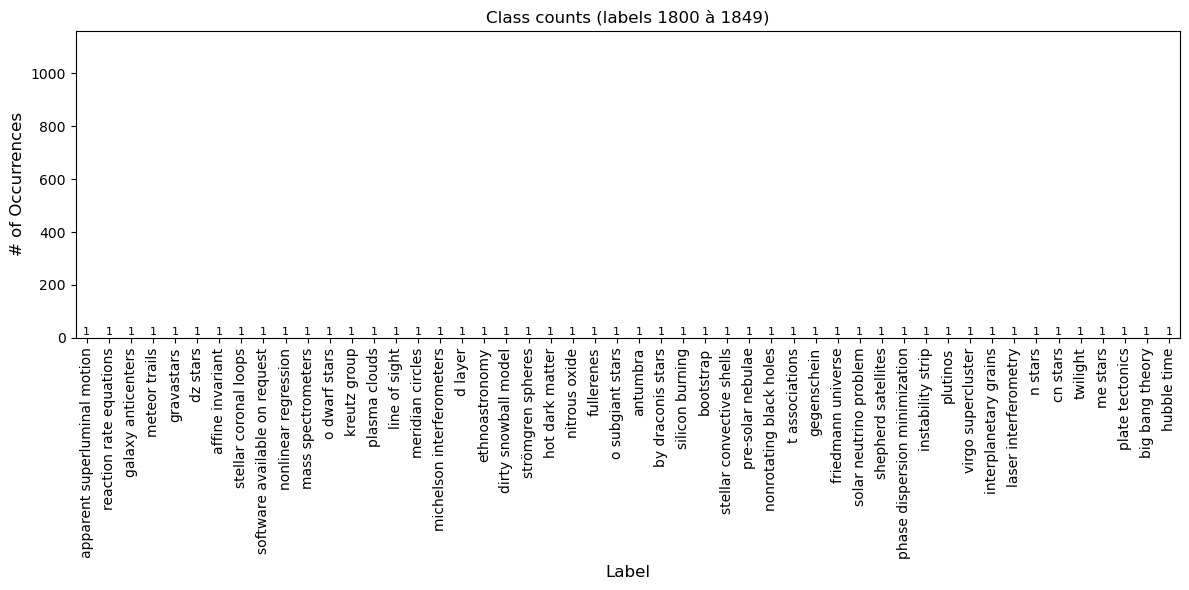

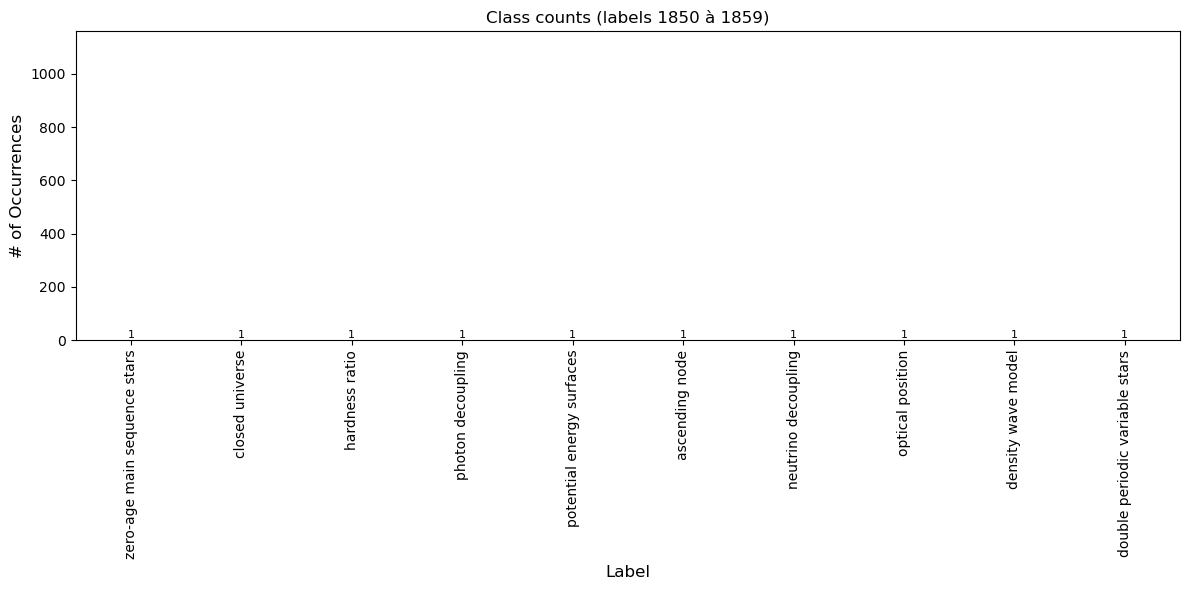

In [6]:

x = df.iloc[:, 5:].sum()
x = x.sort_values(ascending=False)
group_size = 50
num_groups = (len(x) + group_size - 1) // group_size
ymax = x.max() * 1.05  # un peu plus haut pour laisser de la place aux annotations

#plot the class counts in groups of 50
for i in range(num_groups):
    start = i * group_size
    end = min((i + 1) * group_size, len(x))
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=x.index[start:end], y=x.values[start:end], alpha=0.8)
    plt.title(f"Class counts (labels {start} à {end-1})")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(0, ymax)
    rects = ax.patches
    labels_group = x.values[start:end]
    for rect, label in zip(rects, labels_group):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 1, int(label), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

For data balancing we drop label collumn that occurs less than 20 time

In [ ]:
df_clean = df.copy()

# delete labels with less than 20 occurrences
label_counts = df_clean.iloc[:, 1:].sum()  # count des occurrences de chaque label except 'text'
labels_to_keep = label_counts[label_counts >= 20].index
df_clean = df_clean[['text'] + list(labels_to_keep)]


Number of article per number of label

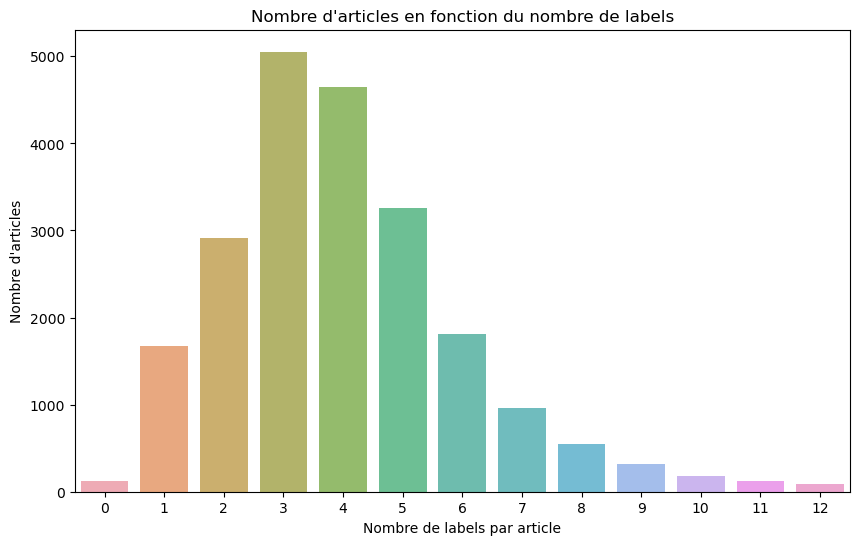

In [13]:
# count the number of labels per article
num_labels_per_article = df_clean.iloc[:, 1:].sum(axis=1)

# count the number of articles for each number of labels
label_counts = num_labels_per_article.value_counts().sort_index()

# Plot the number of articles for each number of labels
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title("Nombre d'articles en fonction du nombre de labels")
plt.xlabel("Nombre de labels par article")
plt.ylabel("Nombre d'articles")
plt.show()


Articles associated with either 0 or more than 9 labels were removed from the dataset, as these cases are underrepresented. Due to the limited number of examples in these categories, the model would struggle to learn meaningful patterns and generalize effectively

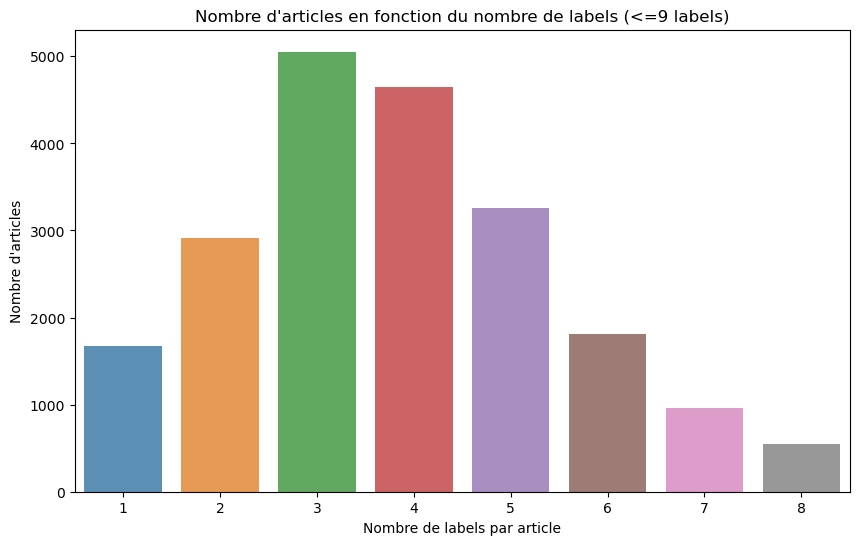

In [14]:
# Filter articles with more than 8 labels and at least 1 label
df_clean = df_clean[(num_labels_per_article <= 8) & (num_labels_per_article > 0)]

# count the number of labels per article again
num_labels_per_article_clean = df_clean.iloc[:, 1:].sum(axis=1)
label_counts = num_labels_per_article_clean.value_counts().sort_index()

# Plot the number of articles for each number of labels
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title("Nombre d'articles en fonction du nombre de labels (<=9 labels)")
plt.xlabel("Nombre de labels par article")
plt.ylabel("Nombre d'articles")
plt.show()

Finally, a few instances in the dataset contained null values in the 'text' column. Since this column serves as the input for our model, these articles were removed from the dataset, as they cannot be used for training or prediction

In [ ]:
df_clean = df_clean.dropna(subset=['text']) # Delete rows with NaN in 'text' column

#### Text column cleanning using :

- Lowercasing : All text was converted to lowercase to reduce vocabulary size and ensure uniformity.
- Non-alphabetical character removal : Using regular expressions, all characters that were not letters
(e.g., punctuation, numbers, symbols) were removed to focus only on semantic content.
- Stopword removal : Common English stopwords (e.g., “the”, “and”, “is”) were removed using the NLTK
stopword list to retain only meaningful words.
- Stemming : Words were reduced to their root forms using the Snowball stemmer. This reduces redun-
dancy and helps the model generalize over different grammatical forms.

In [16]:
regex = re.compile(r'[^a-zA-Z]')
#Remove Stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = regex.sub(" ", text)
    text = ' '.join(text.split())
    return text

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df_clean['text'] = df_clean['text'].apply(lambda x: remove_stopwords(x))
df_clean['text'] = df_clean['text'].apply(lambda x:clean_text(x))
df_clean['text'] = df_clean['text'].apply(stemming)




#### Summary of data preprocessing result on the dataset 

In [17]:
# Display preprocessing results

print("Number of articles before preprocessing:", len(df))
print("Number of labels before preprocessing:", len(df.columns) - 1)  # Subtract 1 for the 'text' column

print("\nNumber of articles after preprocessing:", len(df_clean))
print("Number of retained labels:", len(df_clean.columns) - 1)  # Subtract 1 for the 'text' column

# Display a sample of the 'text' column before and after cleaning
print("\nExample of text before cleaning:")
print(df['text'].iloc[0:3].to_string(index=False))

print("\nExample of text after cleaning:")
print(df_clean['text'].iloc[0:3].to_string(index=False))

# Statistics on text length (before and after cleaning)

# Remove rows with missing text
df = df.dropna(subset=['text'])

# Compute the number of words in each article before cleaning
df_text_length = df['text'].apply(lambda x: len(x.split()))
print("\nAverage text length (before cleaning):", round(df_text_length.mean(), 2))
print("Minimum length:", df_text_length.min())
print("Maximum length:", df_text_length.max())

# Compute the number of words in each article after cleaning
df_clean_text_length = df_clean['text'].apply(lambda x: len(x.split()))
print("\nAverage text length (after cleaning):", round(df_clean_text_length.mean(), 2))
print("Minimum length:", df_clean_text_length.min())
print("Maximum length:", df_clean_text_length.max())

# Distribution of the number of labels per article (before and after cleaning)

print("\nAverage number of labels per article (before cleaning):", round(num_labels_per_article.mean(), 2))
print("Standard deviation:", round(num_labels_per_article.std(), 2))
print("Minimum number of labels:", num_labels_per_article.min())
print("Maximum number of labels:", num_labels_per_article.max())

print("\nAverage number of labels per article (after cleaning):", round(num_labels_per_article_clean.mean(), 2))
print("Standard deviation:", round(num_labels_per_article_clean.std(), 2))
print("Minimum number of labels:", num_labels_per_article_clean.min())
print("Maximum number of labels:", num_labels_per_article_clean.max())

Number of articles before preprocessing: 21702
Number of labels before preprocessing: 1864

Number of articles after preprocessing: 20825
Number of retained labels: 805

Example of text before cleaning:
Dynamic Potential Sputtering of Lunar Analog Ma...
Generation of Low-inclination, Neptune-crossing...
Leveraging the Gravity Field Spectrum for Icy S...

Example of text after cleaning:
dynam potenti sputter lunar analog materi solar...
generat low inclin neptun cross tran neptunian ...
leverag graviti field spectrum ici satellit int...

Average text length (before cleaning): 224.18
Minimum length: 22
Maximum length: 483

Average text length (after cleaning): 154.88
Minimum length: 13
Maximum length: 361

Average number of labels per article (before cleaning): 3.99
Standard deviation: 2.01
Minimum number of labels: 0
Maximum number of labels: 12

Average number of labels per article (after cleaning): 3.81
Standard deviation: 1.68
Minimum number of labels: 1
Maximum number of labels: 8


## 2. Model Selection and Experimental Settings

First we devide our dataset into train (80 %) and test (20 %) datasets : 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_clean['text'], df_clean.iloc[:, 1:], test_size=0.2, random_state=42) #Split the data into training and test sets


For testing purposes, it is recommended to use fewer than 50 labels, as processing 50 labels typically requires approximately one hour of execution time.

In [ ]:
# Select the top x labels based on their occurrence in the training set
x = 50  # Number of top labels to keep
top_labels = y_train.sum().sort_values(ascending=False).head(x).index

# Restreindre y_train et y_test à ces labels
y_train_top = y_train[top_labels]
y_test_top = y_test[top_labels]

#### Binary Relevancce Model

In [ ]:
# Define a machine learning pipeline for multi-label classification using Binary Relevance
# with Logistic Regression as the base classifier

pipeline = Pipeline([
    # Convert raw text into TF-IDF feature vectors, excluding custom stopwords
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    
    # Apply Binary Relevance strategy where one binary classifier is trained per label
    ('clf', BinaryRelevance(LogisticRegression(solver='sag')))
])

# Train the pipeline on the training data
pipeline.fit(x_train, y_train_top)

# Generate predictions on the test data
predictions_1 = pipeline.predict(x_test)

# Evaluate model performance using three key multi-label metrics
accuracy_score_1 = accuracy_score(y_test_top, predictions_1)              # Exact match ratio
f1_score_1 = f1_score(y_test_top, predictions_1, average="micro")         # Micro-averaged F1 score
hamming_loss_1 = hamming_loss(y_test_top, predictions_1)                  # Fraction of labels incorrectly predicted

# Print the evaluation results
print(f"Accuracy: {accuracy_score_1:.4f}")
print(f"F1 Score: {f1_score_1:.4f}")
print(f"Hamming Loss: {hamming_loss_1:.4f}")



#### Classifier Chain Model

In [35]:
# Define a machine learning pipeline using TF-IDF for text feature extraction
# followed by multi-label classification using Classifier Chain with Logistic Regression
pipeline = Pipeline([
    # Transform input text into TF-IDF features while removing custom stopwords
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    
    # Apply Classifier Chain strategy using Logistic Regression as the base estimator
    ('clf', ClassifierChain(LogisticRegression(solver='sag')))
])

# Train the pipeline on the training set
pipeline.fit(x_train, y_train_top)

# Predict the labels on the test set
predictions_4 = pipeline.predict(x_test)

# Evaluate the performance using three standard multi-label metrics
accuracy_score_4 = accuracy_score(y_test_top, predictions_4)               # Subset accuracy (exact match)
f1_score_4 = f1_score(y_test_top, predictions_4, average="micro")          # Micro-averaged F1 score
hamming_loss_4 = hamming_loss(y_test_top, predictions_4)                   # Hamming loss (fraction of wrong labels)

# Print the evaluation results
print("Accuracy = ", accuracy_score_4)
print("F1 score is ", f1_score_4)
print("Hamming Loss is ", hamming_loss_4)


Accuracy =  0.37070828331332534
F1 score is  0.3258408531583265
Hamming Loss is  0.01973109243697479


#### Label Powerset Model

In [37]:
# Define a machine learning pipeline that applies TF-IDF vectorization followed by
# a Label Powerset strategy with a Logistic Regression classifier
pipeline = Pipeline([
    # Convert raw text data into TF-IDF features, removing custom stopwords
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),

    # Apply Label Powerset multi-label classification using Logistic Regression
    ('clf', LabelPowerset(LogisticRegression(max_iter=120)))  # Increased max_iter for convergence
])

# Train the model on the training data
pipeline.fit(x_train, y_train_top)

# Generate predictions on the test set
predictions_2 = pipeline.predict(x_test)

# Evaluate the performance of the model using three common multi-label metrics
accuracy_score_2 = accuracy_score(y_test_top, predictions_2)               # Exact match ratio
f1_score_2 = f1_score(y_test_top, predictions_2, average="micro")          # Micro-averaged F1-score
hamming_loss_2 = hamming_loss(y_test_top, predictions_2)                   # Hamming loss (lower is better)

# Display evaluation results
print("Accuracy = ", accuracy_score_2)
print("F1 score is ", f1_score_2)
print("Hamming Loss is ", hamming_loss_2)

Accuracy =  0.3675870348139256
F1 score is  0.2796069643164972
Hamming Loss is  0.020067226890756303


In [50]:
# Define a machine learning pipeline that includes TF-IDF vectorization followed by 
# a multi-label classification using Label Powerset and a Random Forest classifier
pipeline = Pipeline([
    # Convert the input text into TF-IDF vectors, removing custom stopwords
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),

    # Use the Label Powerset strategy with a Random Forest classifier
    ('clf', LabelPowerset(RandomForestClassifier(
        n_estimators=200,     # Use 200 decision trees in the forest
        max_depth=None,       # Allow trees to grow until all leaves are pure or contain <min_samples_split
        random_state=42,      # Fix the seed for reproducibility
        n_jobs=-1             # Use all available CPU cores for parallel processing
    )))
])

# Train the pipeline on the training dataset
pipeline.fit(x_train, y_train_top)

# Predict the labels for the test dataset
predictions_rf_lp = pipeline.predict(x_test)

# Evaluate the model using three metrics
accuracy_score_5 = accuracy_score(y_test_top, predictions_rf_lp)               # Subset accuracy
f1_score_5 = f1_score(y_test_top, predictions_rf_lp, average="micro")          # Micro-averaged F1-score
hamming_loss_5 = hamming_loss(y_test_top, predictions_rf_lp)                   # Hamming loss

# Print evaluation results
print("Accuracy = ", accuracy_score_5)
print("F1 score is ", f1_score_5)
print("Hamming Loss is ", hamming_loss_5)


Accuracy =  0.32653061224489793
F1 score is  0.06261585993820803
Hamming Loss is  0.021853541416566626


In [48]:
# Define a machine learning pipeline with TF-IDF vectorization followed by a Label Powerset classification model
pipeline = Pipeline([
    #Convert raw text into TF-IDF features, excluding custom stopwords
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),

    #Use Label Powerset strategy with a Multi-Layer Perceptron classifier
    ('clf', LabelPowerset(MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),  # Three hidden layers with 256, 128, and 64 neurons respectively
        activation='relu',                 # ReLU activation function for non-linearity
        solver='adam',                     # Adam optimizer for weight updates
        max_iter=200,                      # Maximum number of training iterations
        random_state=42                    # Set random seed for reproducibility
    )))
])

# Train the model on the training data
pipeline.fit(x_train, y_train_top)

# Make predictions on the test data
predictions_nn_lp = pipeline.predict(x_test)

# Evaluate the model using common multi-label metrics
accuracy_score_6 = accuracy_score(y_test_top, predictions_nn_lp)
f1_score_6 = f1_score(y_test_top, predictions_nn_lp, average="micro")
hamming_loss_6 = hamming_loss(y_test_top, predictions_nn_lp)

# Print the evaluation results
print("Accuracy = ", accuracy_score_6)
print("F1 score is ", f1_score_6)
print("Hamming Loss is ", hamming_loss_6)


Accuracy =  0.2936374549819928
F1 score is  0.3585763388402262
Hamming Loss is  0.027779111644657864


#### SciBERT model

In [ ]:


# 1. Préparation du dataset pour SciBERT
class SciXDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts.tolist()
        self.labels = labels.values.astype('float32')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# 2. Modèle SciBERT pour classification multilabel
class SciBERTMultiLabel(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Utiliser le [CLS] token
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        probs = torch.sigmoid(logits)
        if labels is not None:
            loss_fn = nn.BCELoss()
            loss = loss_fn(probs, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}

# 3. Préparation des données
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
n_labels = y_train.shape[1]

train_dataset = SciXDataset(x_train, y_train, tokenizer)
test_dataset = SciXDataset(x_test, y_test, tokenizer)

# 4. Instanciation du modèle
model = SciBERTMultiLabel(n_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 5. DataLoader, Optimizer, etc.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)



This part refers to the trainning of the SciBERT model and is very power consuming (20 hours computaion time). Proceed carefully

In [ ]:
# 6. Boucle d'entraînement (exemple simple)
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        torch.save(model.state_dict(), "Model_save/scibert_multilabel_model.pt")


Model testing

Note that SciBERT model was to big to be upload on GitHub. To verify these results again, please retrain a new model (note that this may take some time) or use an untrained model.

In [55]:
model.load_state_dict(torch.load("Model_save/scibert_multilabel_model.pt", map_location=device))

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs['logits'].cpu().numpy()
        preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

accuracy_score_3 = accuracy_score(all_labels, all_preds)
f1_score_3 = f1_score(all_labels, all_preds, average="micro")
hamming_loss_3 = hamming_loss(all_labels, all_preds)

print('Accuracy = ', accuracy_score_3)
print('F1 score is ', f1_score_3)
print('Hamming Loss is ', hamming_loss_3)

Evaluating: 100%|██████████| 261/261 [20:30<00:00,  4.72s/it]


Accuracy =  0.024729891956782712
F1 score is  0.24596260634775077
Hamming Loss is  0.004414486291410974


## 3. Evaluation and Metrics

In [51]:
print('Results for Binary Relevance Model:')
print('Accuracy = ', accuracy_score_1)
print('F1 score is ', f1_score_1)
print('Hamming Loss is ', hamming_loss_1)

print('\nResults for Classifier Chain Model:')
print("Accuracy = ", accuracy_score_4)
print('F1 score is ', f1_score_4)
print('Hamming Loss is ', hamming_loss_4)

print('\nResults for Label Powerset Model:')
print("Accuracy = ", accuracy_score_2)
print('F1 score is ', f1_score_2)
print('Hamming Loss is ', hamming_loss_2)

print('\nResults for Label Powerset (Random Forest) Model:')
print("Accuracy = ", accuracy_score_5)
print('F1 score is ', f1_score_5)
print('Hamming Loss is ', hamming_loss_5)

print('\nResults for Label Powerset (MLP) Model:')
print("Accuracy = ", accuracy_score_6)
print('F1 score is ', f1_score_6)
print('Hamming Loss is ', hamming_loss_6)

print('\nResults for SciBERT Model:')
print('Accuracy = ', accuracy_score_3)
print('F1 score is ', f1_score_3)
print('Hamming Loss is ', hamming_loss_3)



Results for Binary Relevance Model:
Accuracy =  0.37599039615846336
F1 score is  0.33420707732634336
Hamming Loss is  0.01951500600240096

Results for Classifier Chain Model:
Accuracy =  0.37070828331332534
F1 score is  0.3258408531583265
Hamming Loss is  0.01973109243697479

Results for Label Powerset Model:
Accuracy =  0.3675870348139256
F1 score is  0.2796069643164972
Hamming Loss is  0.020067226890756303

Results for Label Powerset (Random Forest) Model:
Accuracy =  0.32653061224489793
F1 score is  0.06261585993820803
Hamming Loss is  0.021853541416566626

Results for Label Powerset (MLP) Model:
Accuracy =  0.2936374549819928
F1 score is  0.3585763388402262
Hamming Loss is  0.027779111644657864

Results for SciBERT Model:
Accuracy =  0.024729891956782712
F1 score is  0.24596260634775077
Hamming Loss is  0.004414486291410974


#### Comparison

c:\Users\Mathis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\Mathis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\Mathis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


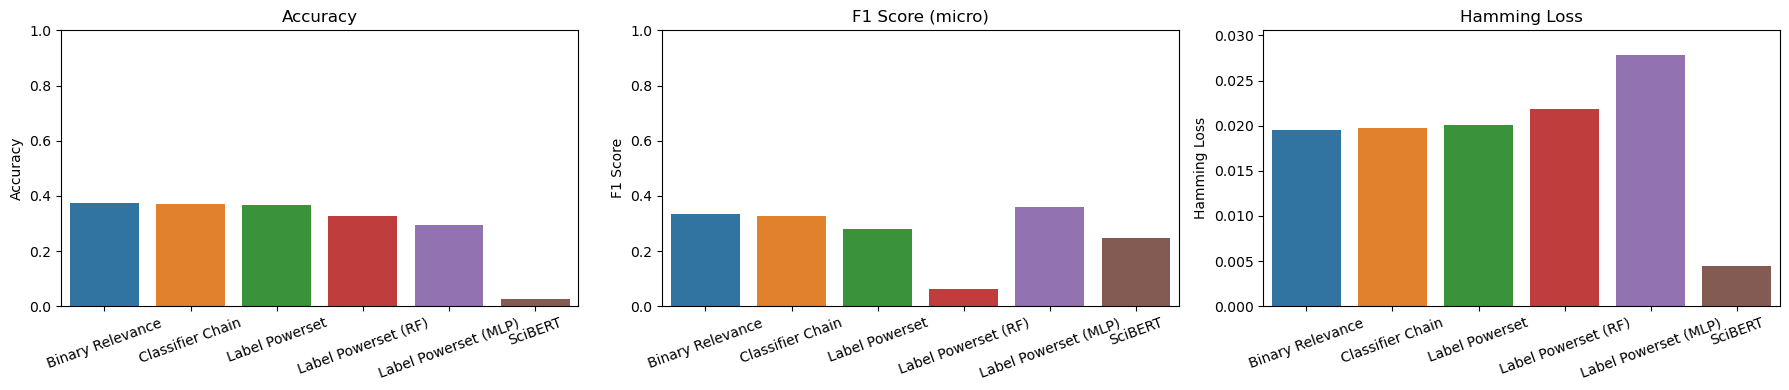

In [52]:
model_names = [
    "Binary Relevance",
    "Classifier Chain",
    "Label Powerset",
    "Label Powerset (RF)",
    "Label Powerset (MLP)",
    "SciBERT"
]

accuracy_scores = [
    accuracy_score_1,
    accuracy_score_4,
    accuracy_score_2,
    accuracy_score_5,
    accuracy_score_6,
    accuracy_score_3
]

f1_scores = [
    f1_score_1,
    f1_score_4,
    f1_score_2,
    f1_score_5,
    f1_score_6,
    f1_score_3
]

hamming_losses = [
    hamming_loss_1,
    hamming_loss_4,
    hamming_loss_2,
    hamming_loss_5,
    hamming_loss_6,
    hamming_loss_3
]

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.barplot(x=model_names, y=accuracy_scores)
plt.title("Accuracy")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xticks(rotation=20)

plt.subplot(1, 3, 2)
sns.barplot(x=model_names, y=f1_scores)
plt.title("F1 Score (micro)")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.xticks(rotation=20)

plt.subplot(1, 3, 3)
sns.barplot(x=model_names, y=hamming_losses)
plt.title("Hamming Loss")
plt.ylim(0, max(hamming_losses) * 1.1)
plt.ylabel("Hamming Loss")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

## 4. Results Analysis

Check the report for this part
